# Grupo A3 - Classification using feature vectors

 In this project we will extract features from the shapes present in the images in order to correctly classify the EMNIST dataset. 
 
The features to be extracted are:

TODO: choose features
- area of the black pixels (foreground/shape)
- area of the white pixels (background)
- perimeter of the shape
- bounding-box area
- major axis length
- solidity
- extent
- equivalent-diameter
- centroid (x and y coordinates)
- convex_area

The classifiers that will be used are: 
- Nearest Neighbors
- SVC (SVM for classification, C-Support Vector Classification.)
- Gaussian Process
- Decision Tree
- Random Forest
- MLP (Multi-Layer Perceptron)
- Ada Boost
- Gaussian NB
- Quadratic Discriminant Analysis

We will use the classifiers from scikit-learn and follow the scheme present in https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

#  Loading Data

## Imports

In [124]:
import sys
sys.path.append('../../')

from sarpy.datasets import load_emnist
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from skimage import filters
from skimage.morphology import disk, binary_dilation

## Loading data set and binarizing the images

In [125]:
X_train, y_train, X_test, y_test, X_valid, y_valid, mapping, nb_classes = load_emnist('balanced', validation=True)
X_train = np.squeeze(X_train)
X_valid = np.squeeze(X_valid)
X_test = np.squeeze(X_test)
y_train = np.ravel(y_train)
y_valid = np.ravel(y_valid)
y_test  = np.ravel(y_test)
print(np.shape(X_train), np.shape(y_train))

reshape testing: 100%|██████████| 18800/18800 [00:00<00:00, 87112.49it/s]


Train size: 94000
Test size: 18800
Validation size: 18800
# classes: 47
(94000, 28, 28) (94000,)


### Reducing Training dataset

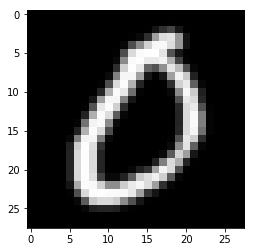

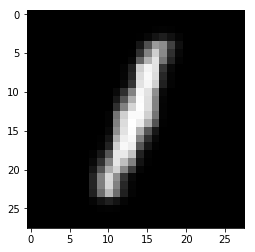

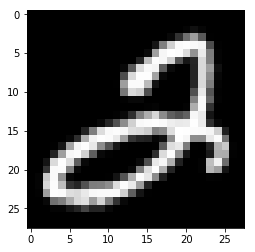

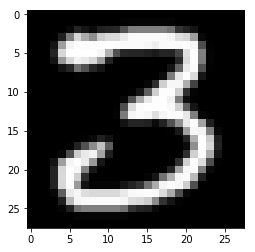

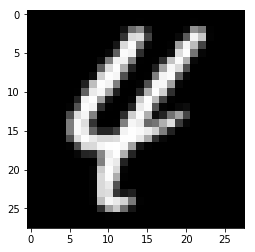

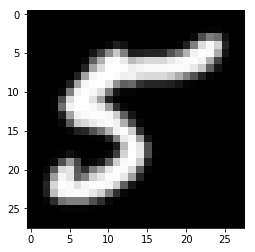

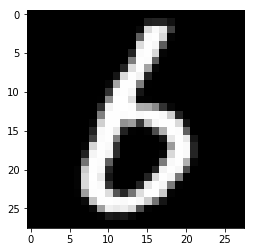

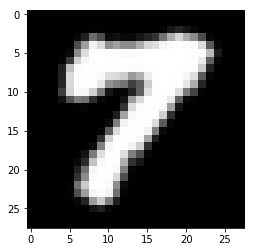

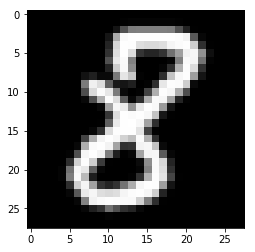

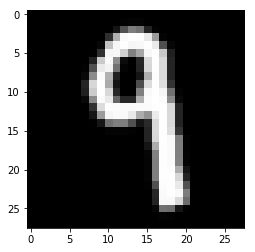

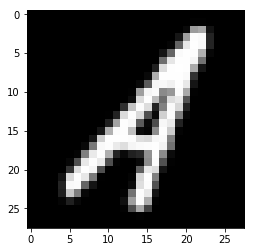

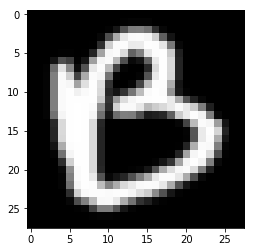

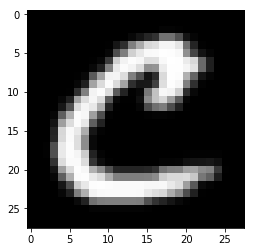

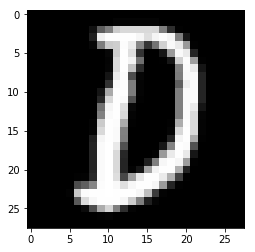

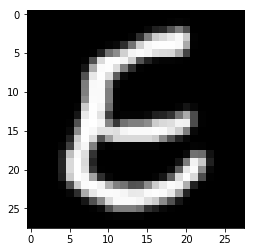

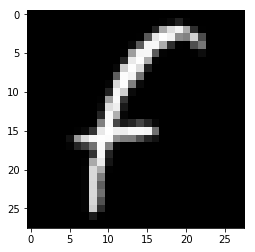

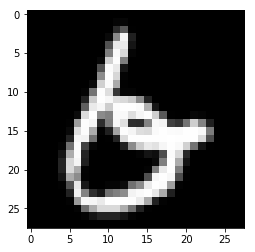

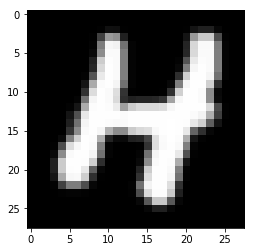

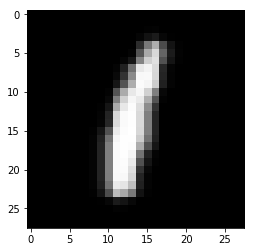

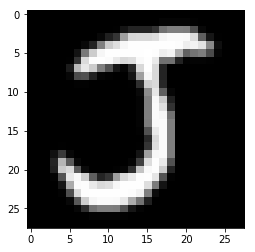

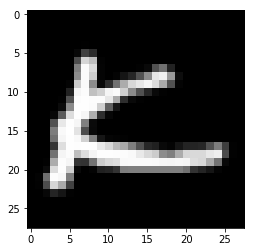

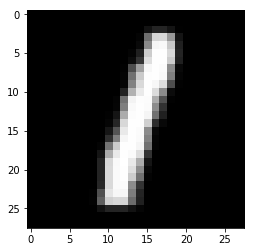

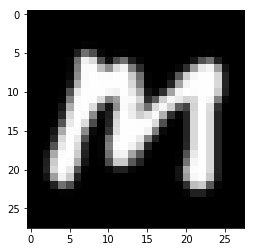

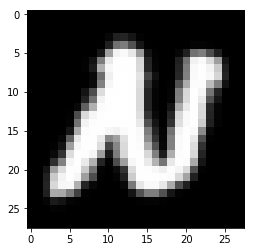

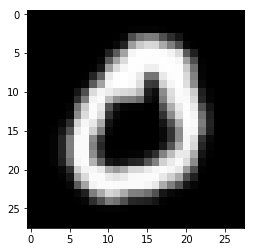

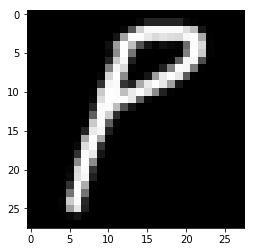

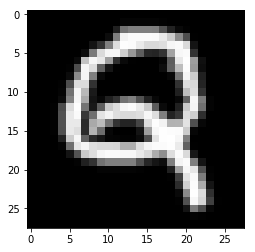

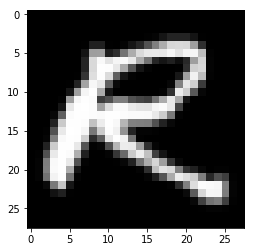

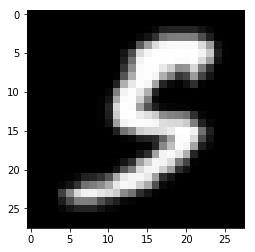

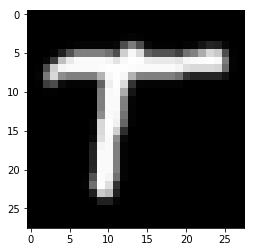

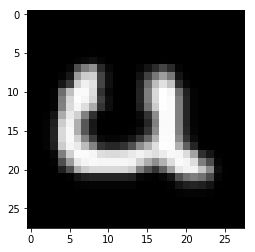

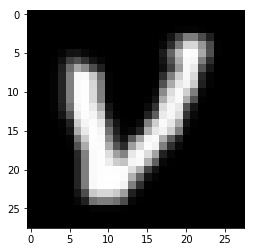

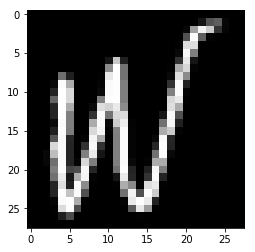

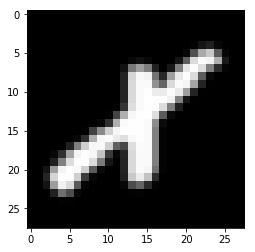

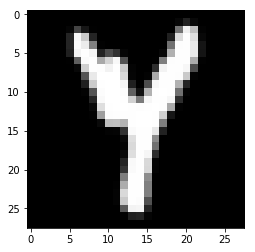

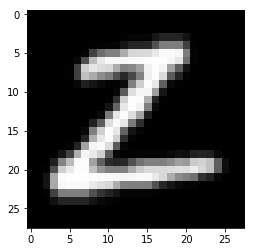

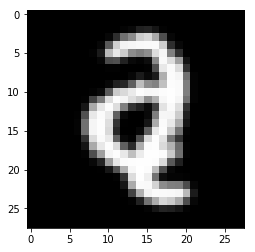

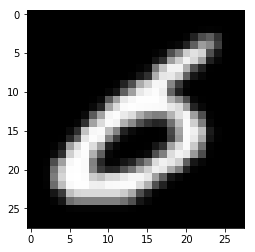

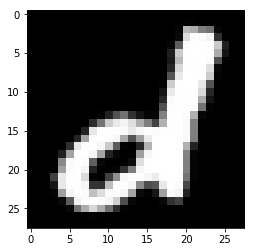

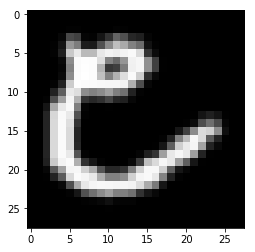

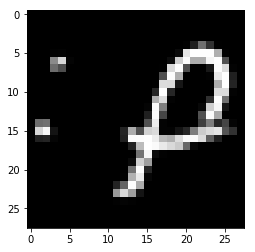

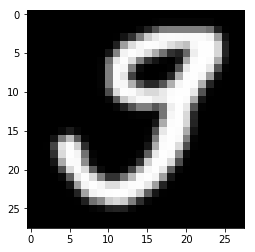

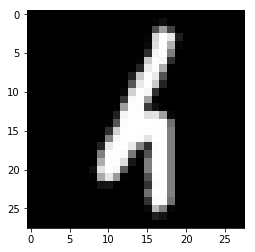

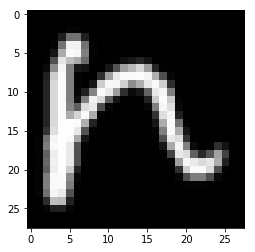

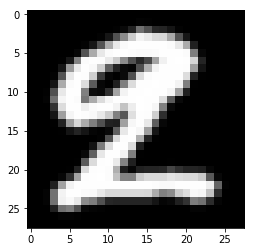

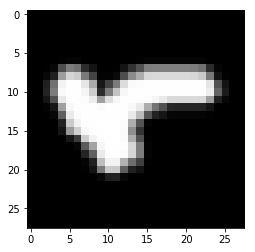

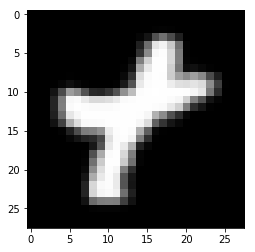

In [139]:
images_class = []
for class_ in mapping:
    images_class += [np.where(y_train == class_)[0]]

X_train_red = []
y_train_red = []
for class_ in images_class:
    index_class = np.random.choice(class_, 300, replace=False)
    X_train_red += [X_train[index_class]]
    y_train_red += [y_train[class_[0]]]*300
    plt.imshow(np.squeeze(X_train[class_[0]]), cmap = 'gray')
    plt.show()
X_train_red = np.array(X_train_red).reshape((14100, 28, 28))

### Extracting foreground with a priori threshold

In [140]:
def bin_image(imset, thresh = 40):
    imsetb = imset > thresh
    imsetb = imsetb.astype(int)
    return imsetb

X_trainb = bin_image(X_train_red, 50)
X_validb = bin_image(X_valid, 50)
X_testb = bin_image(X_test, 50)

0


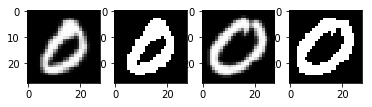

1


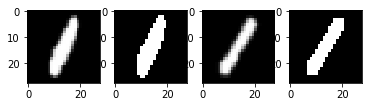

2


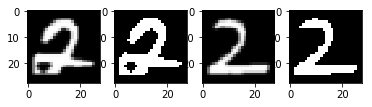

3


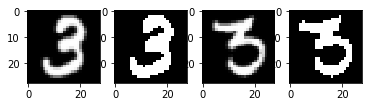

4


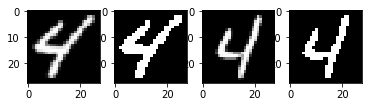

5


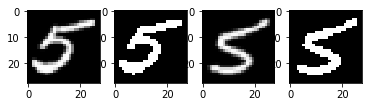

6


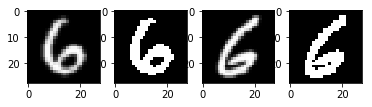

7


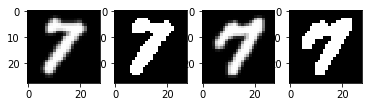

8


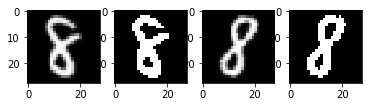

9


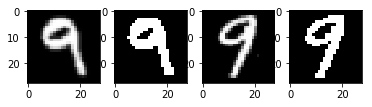

10


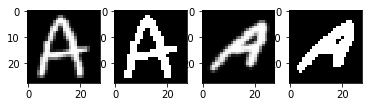

11


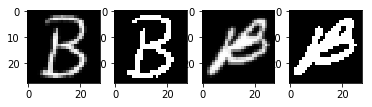

12


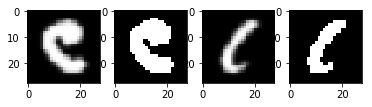

13


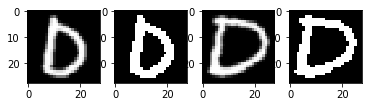

14


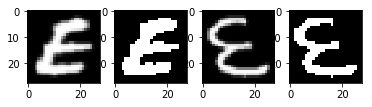

15


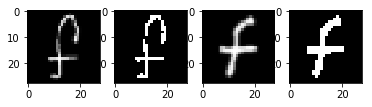

16


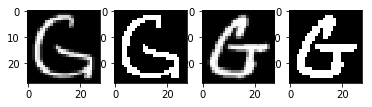

17


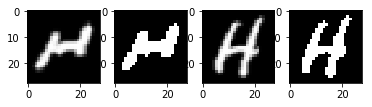

18


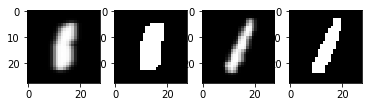

19


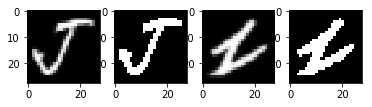

20


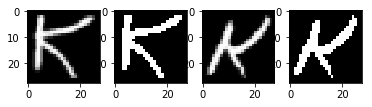

21


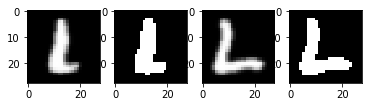

22


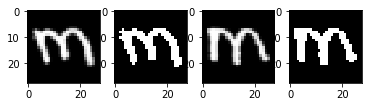

23


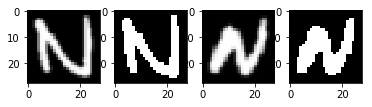

24


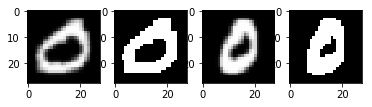

25


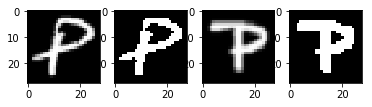

26


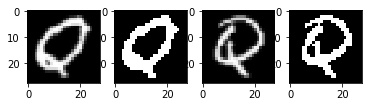

27


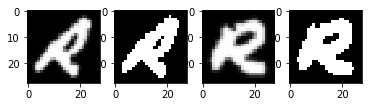

28


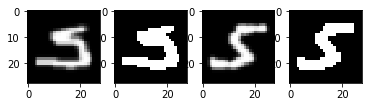

29


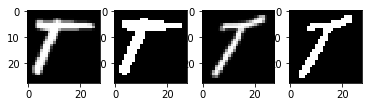

30


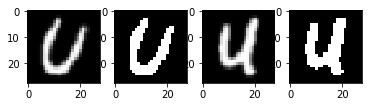

31


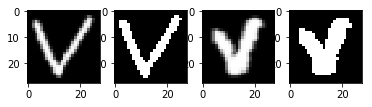

32


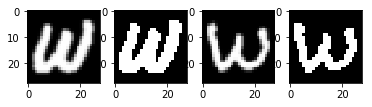

33


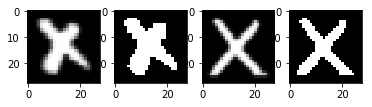

34


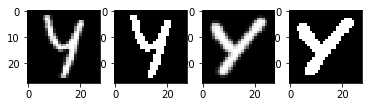

35


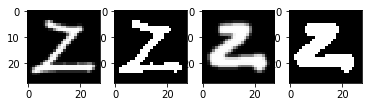

36


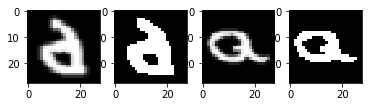

37


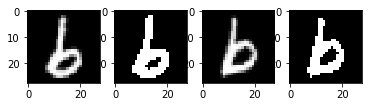

38


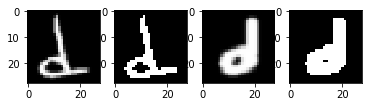

39


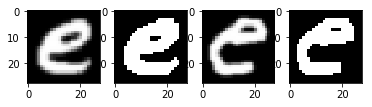

40


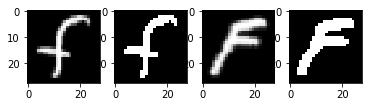

41


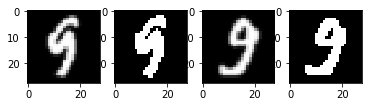

42


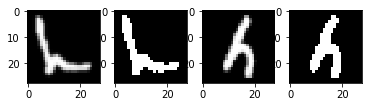

43


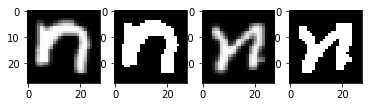

44


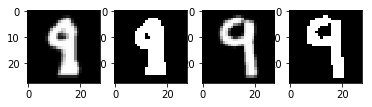

45


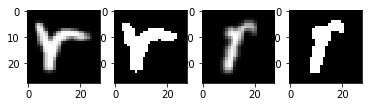

46


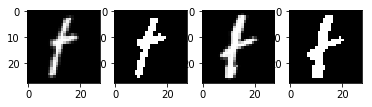

In [194]:
for i in range(47):
    plt.subplot(1, 4, 1)
    plt.imshow(X_train_red[i*300+13], cmap='gray')
    plt.subplot(1, 4, 2)
    plt.imshow(X_trainb[i*300+13], cmap='gray')
    plt.subplot(1, 4, 3)
    plt.imshow(X_test[np.where(y_test == i)[0][0]], cmap='gray')
    plt.subplot(1, 4, 4)
    plt.imshow(X_testb[np.where(y_test == i)[0][0]], cmap='gray')
    print(y_train_red[i*300])
    plt.show()

### Extracting foreground  with Otsu

In [163]:
def bin_otsu(images):
    new_images = []
    for image in images:
        t  = filters.threshold_otsu(image)
        new_images += [(image>t).astype(int)]
    return new_images

In [164]:
X_train_otsu = bin_otsu(X_train_red)
X_valid_otsu = bin_otsu(X_valid)
X_test_otsu = bin_otsu(X_test)

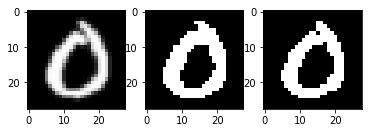

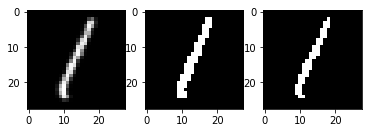

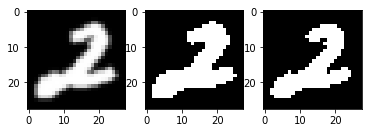

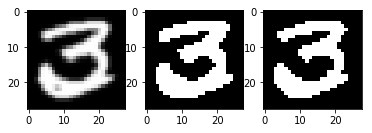

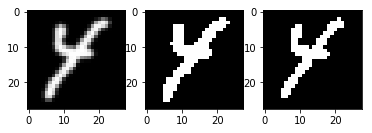

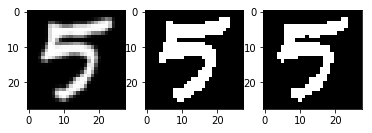

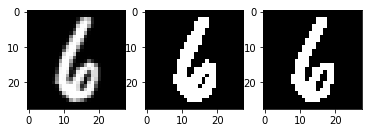

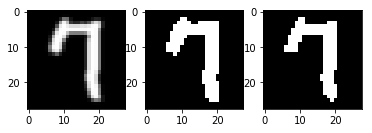

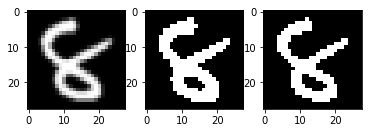

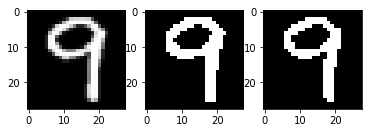

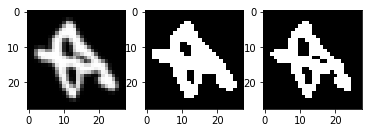

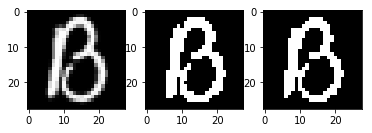

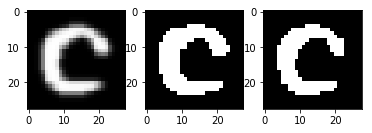

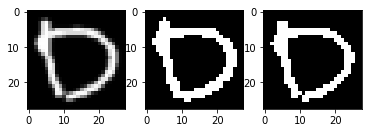

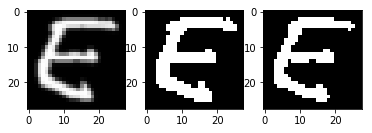

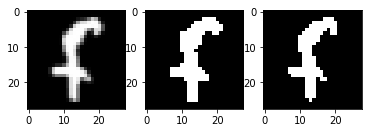

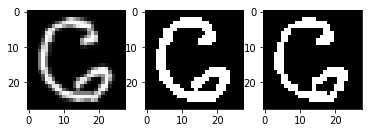

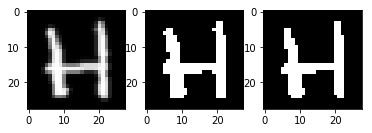

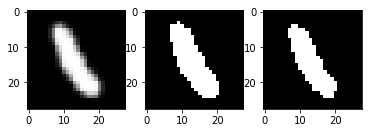

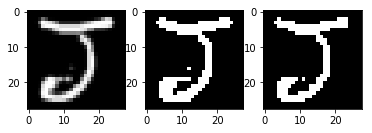

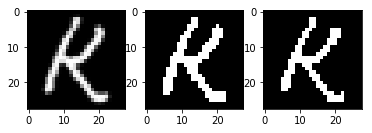

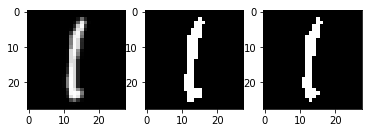

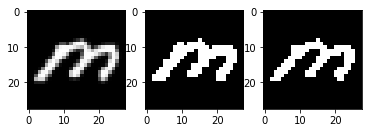

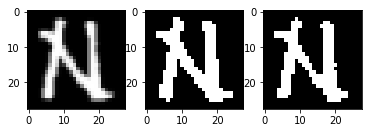

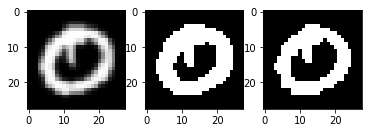

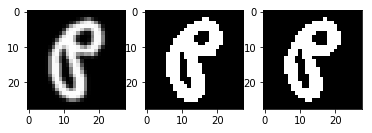

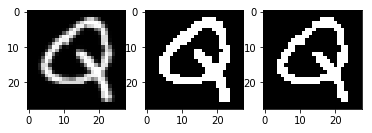

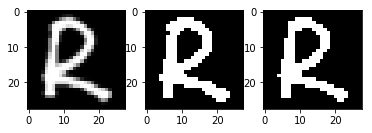

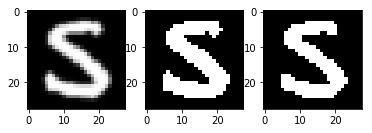

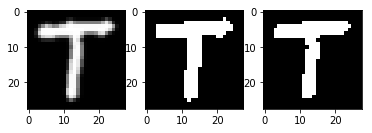

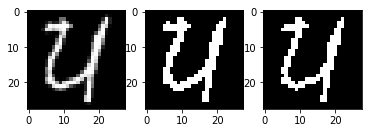

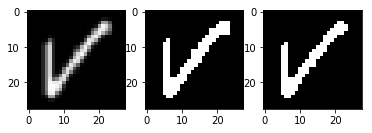

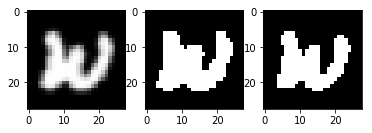

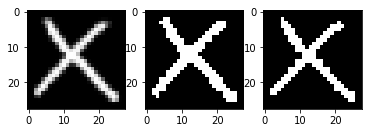

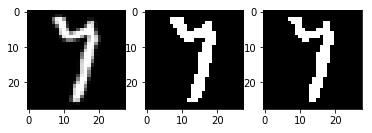

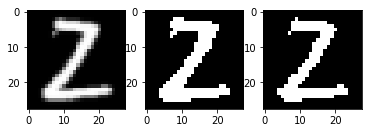

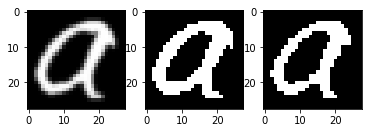

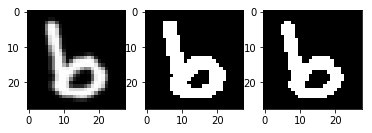

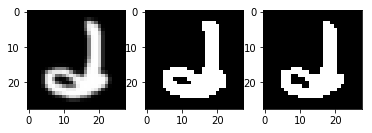

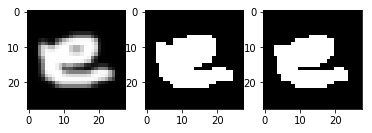

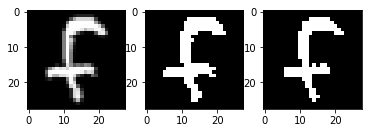

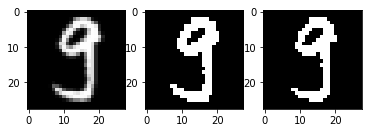

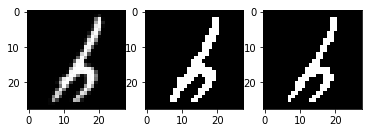

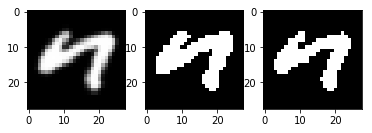

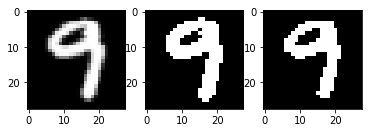

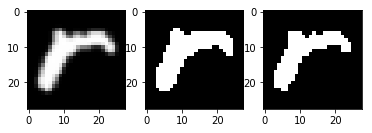

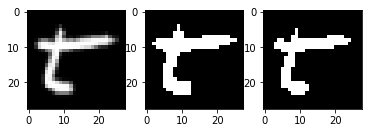

In [165]:
for i in range(47):
    plt.subplot(1, 3, 1)
    plt.imshow(X_train_red[i*300], cmap='gray')
    plt.subplot(1, 3, 2)
    plt.imshow(X_trainb[i*300], cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(X_train_otsu[i*300], cmap='gray')
    plt.show()

## Performing morphologic transforms to correct connectivity

In [166]:
def connect(imgs):
    disk3 = disk(2)
    new_imgs = []
    coefs = []
    for img, i in zip(imgs, range(len(imgs))):
        while np.max(label(img)) > 2:
            img = binary_dilation(img, disk3)
            coefs+= [i]
        new_imgs += [img]
    return new_imgs, np.unique(coefs)

In [182]:
def remove_noise(imgs, thresh):
    new_imgs = []
    coefs = []
    for img, i in zip(imgs, range(len(imgs))):
        imgl = label(img)
        new_img = np.copy(img)
        if np.max(imgl) > 1:
            props = regionprops(imgl)
            areas = [props[i].area for i in range(np.max(imgl))]
            for area, j in zip(areas, range(len(areas))):
                if area < thresh:
                    coefs +=[i]
                    a, b, c, d = props[j].bbox
                    new_img[a:c, b:d] = 0
        new_imgs += [new_img] 
    return new_imgs, coefs
        

In [216]:
X_train_otsu_clean, coefs = remove_noise(X_train_otsu, 10)
X_test_otsu_clean, coefst = remove_noise(X_test_otsu, 10)

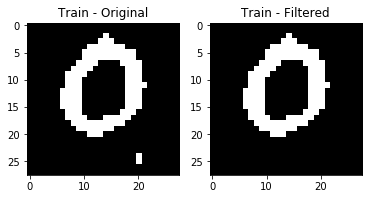

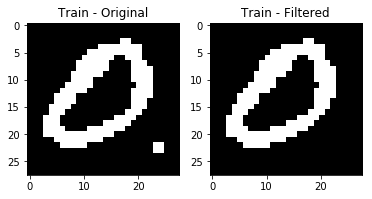

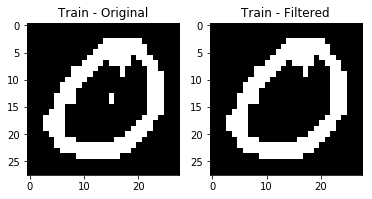

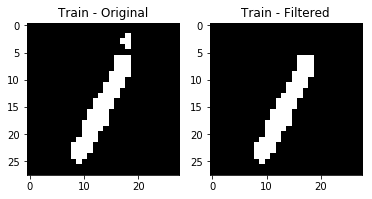

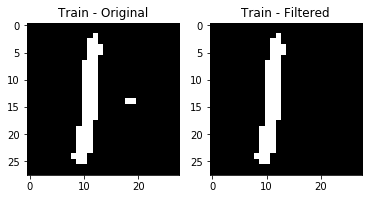

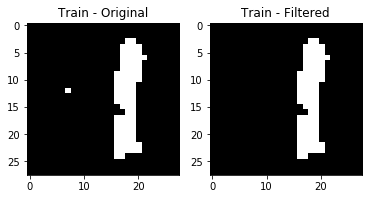

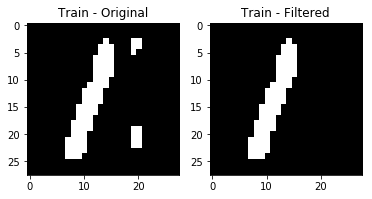

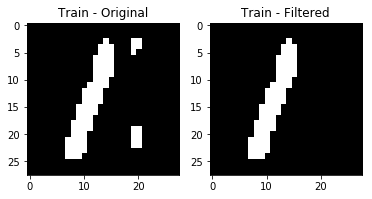

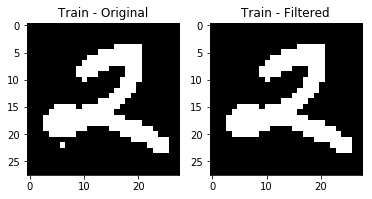

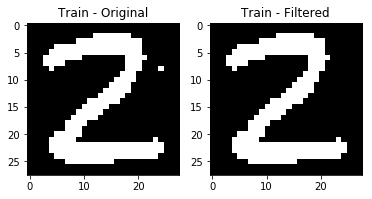

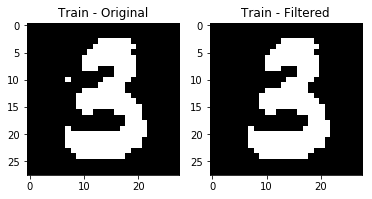

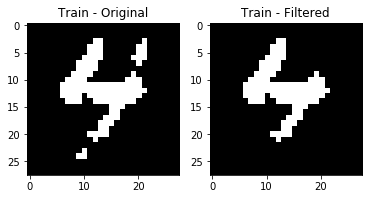

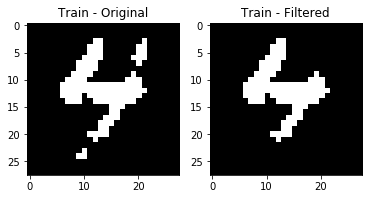

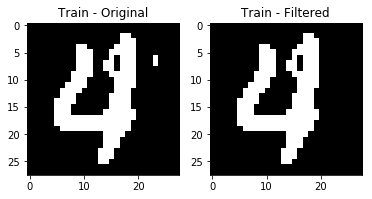

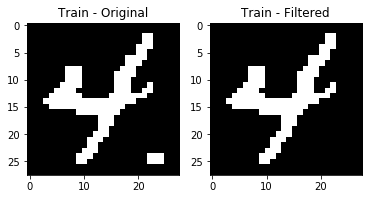

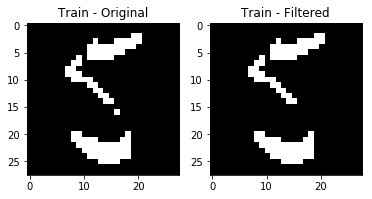

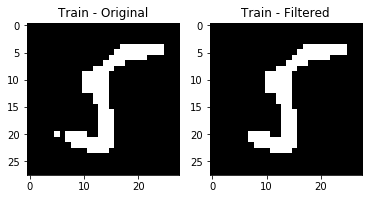

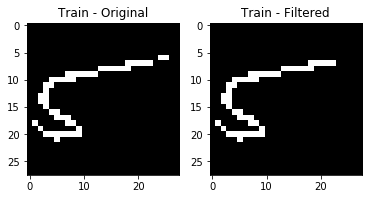

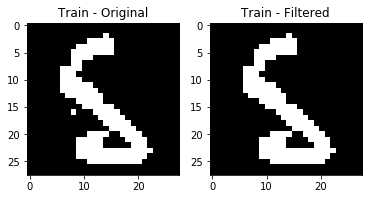

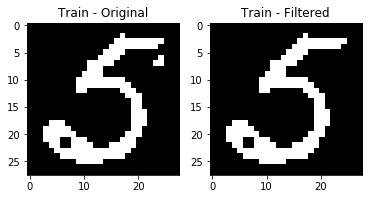

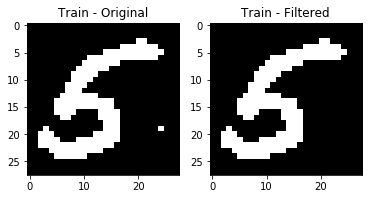

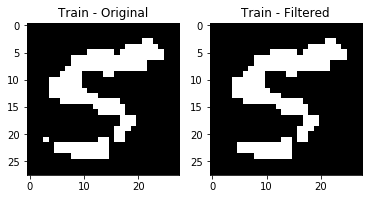

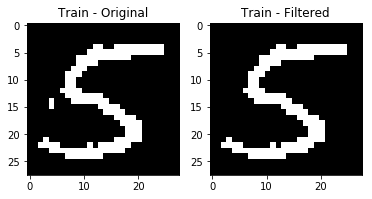

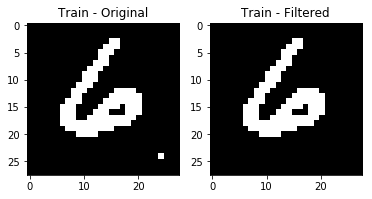

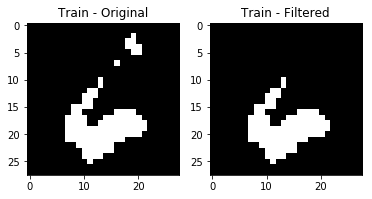

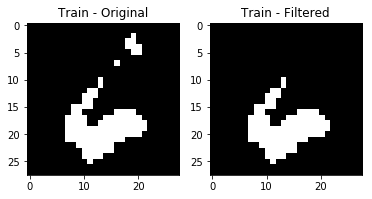

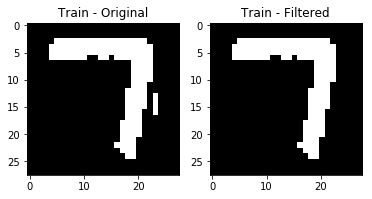

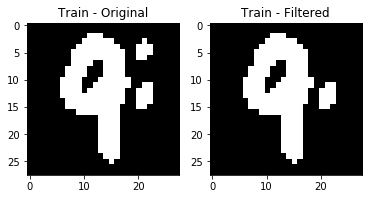

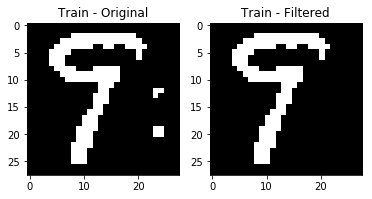

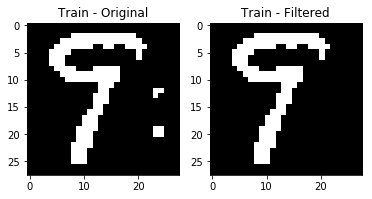

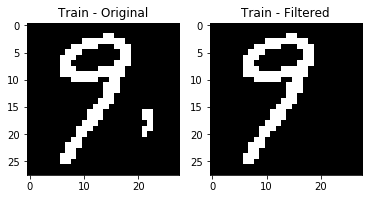

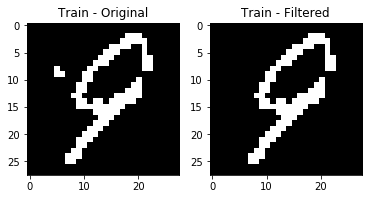

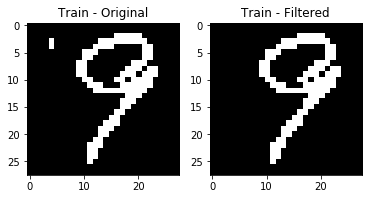

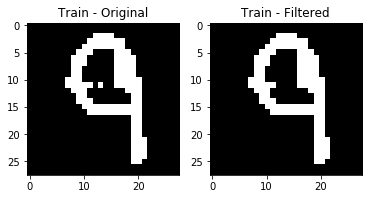

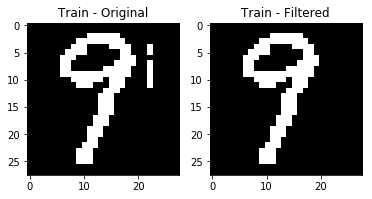

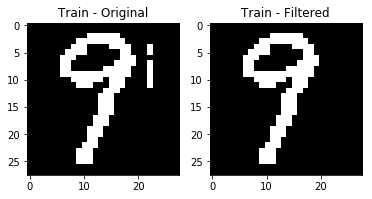

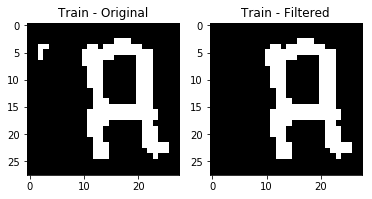

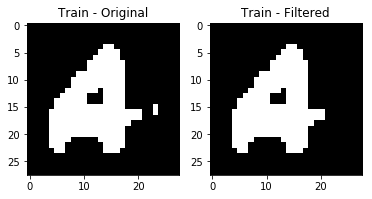

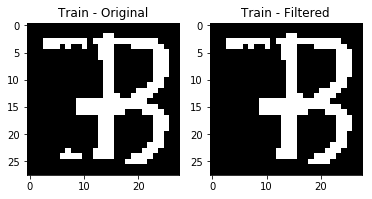

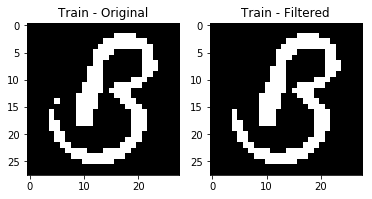

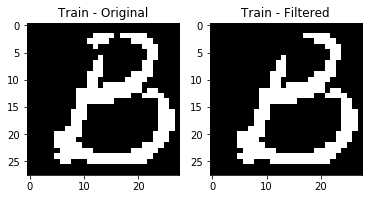

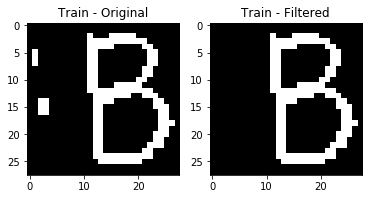

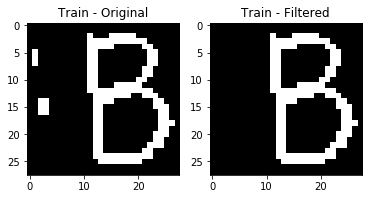

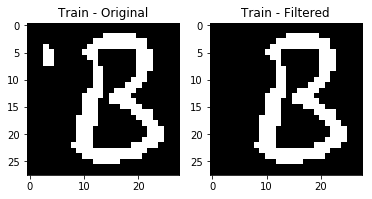

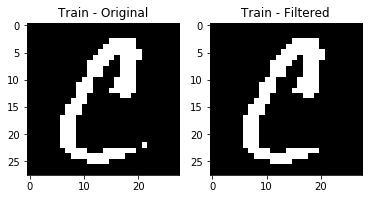

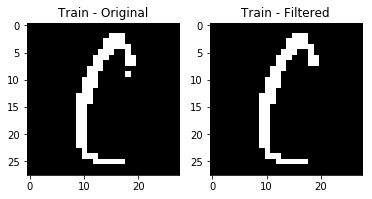

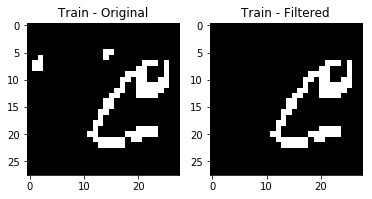

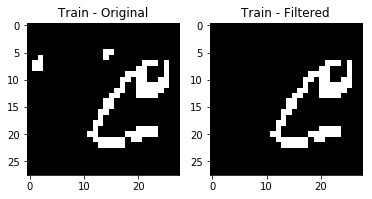

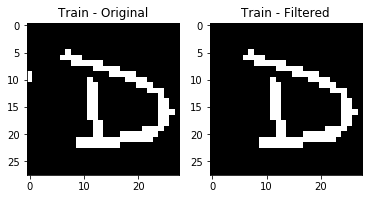

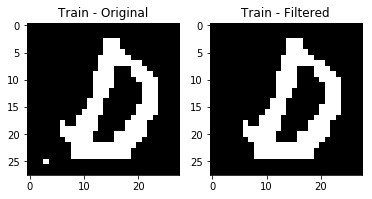

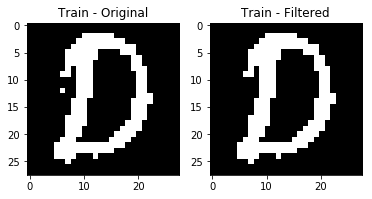

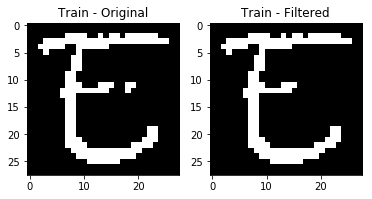

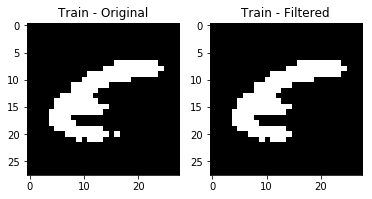

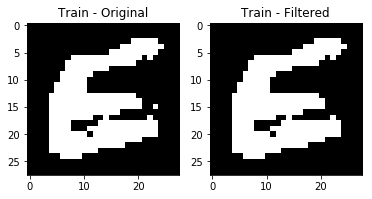

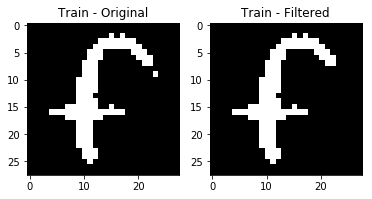

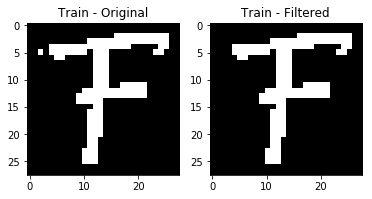

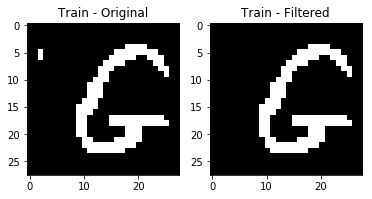

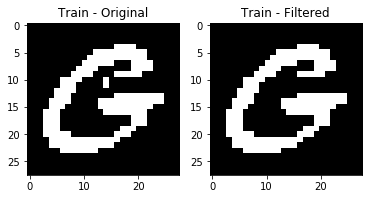

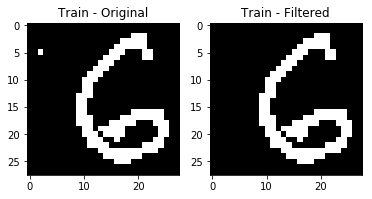

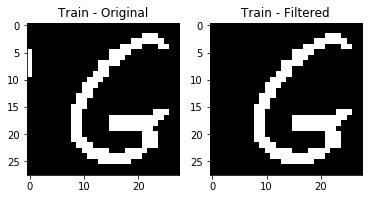

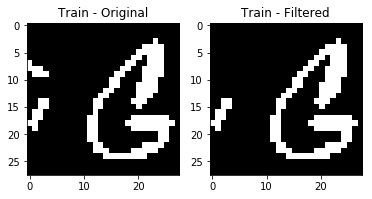

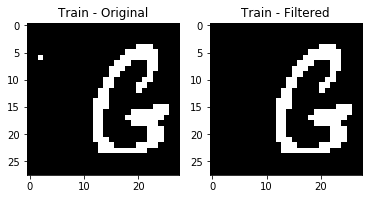

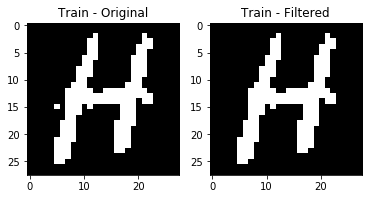

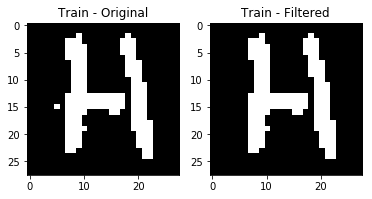

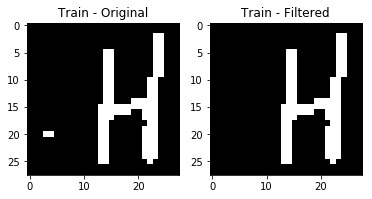

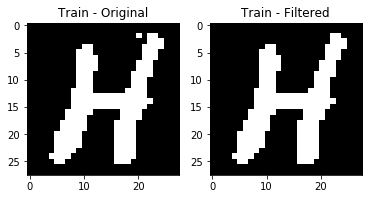

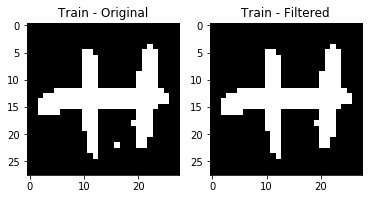

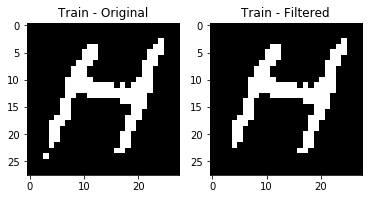

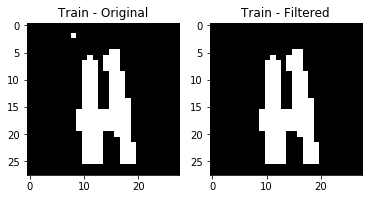

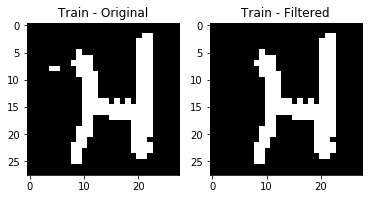

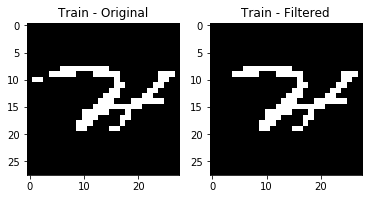

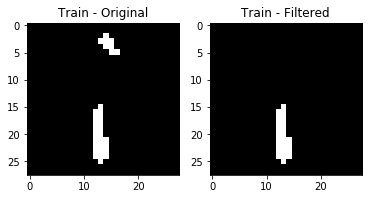

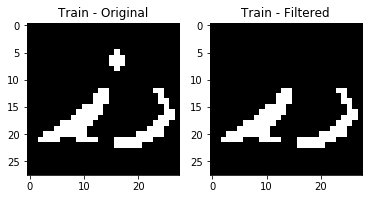

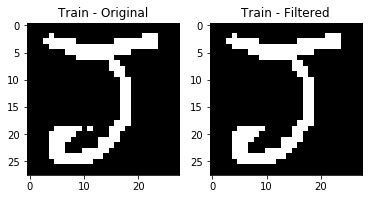

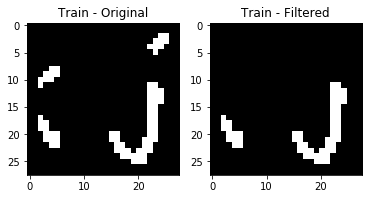

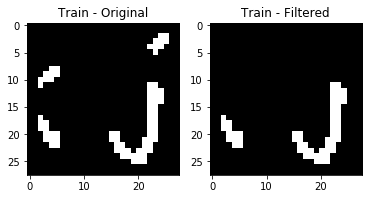

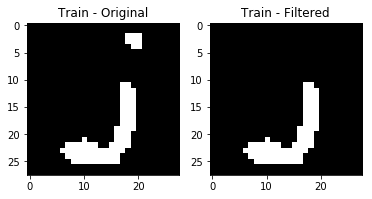

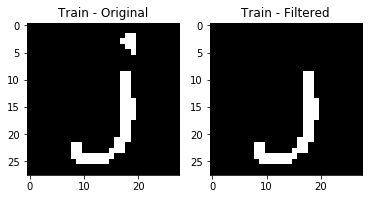

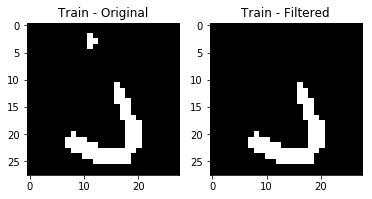

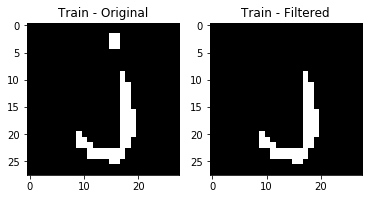

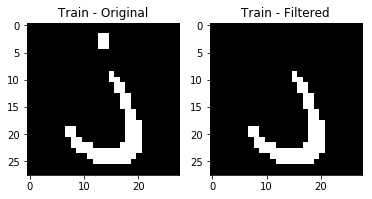

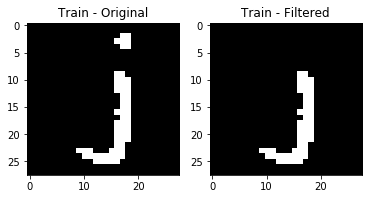

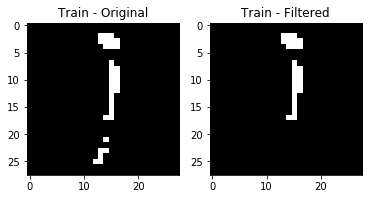

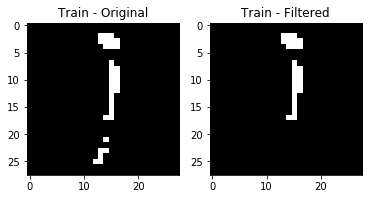

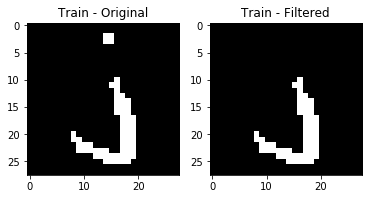

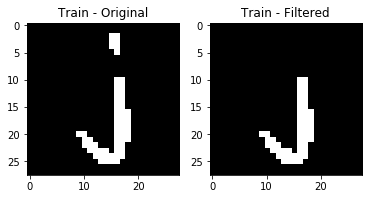

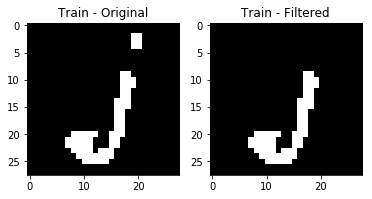

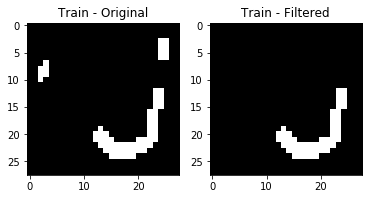

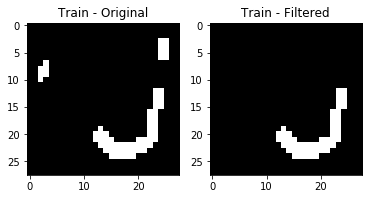

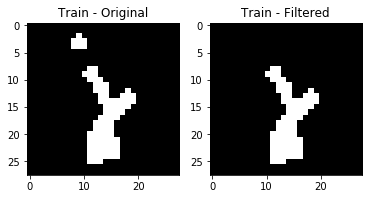

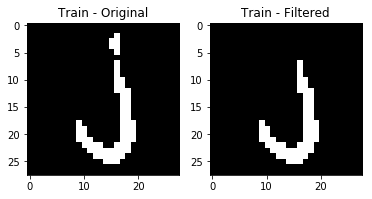

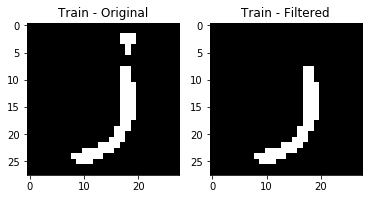

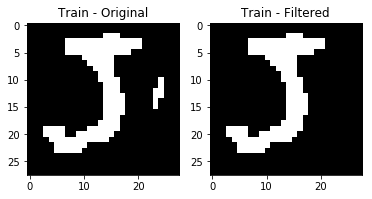

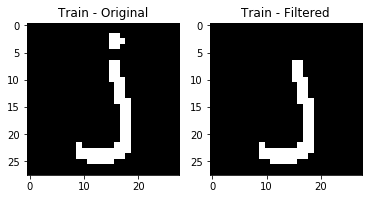

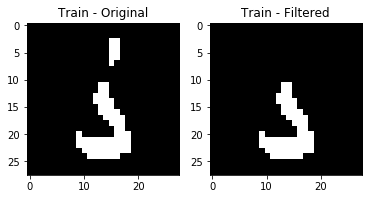

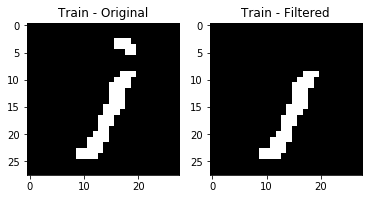

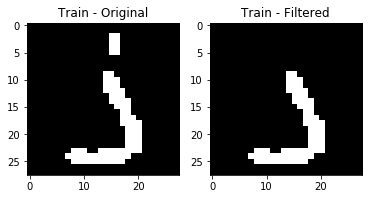

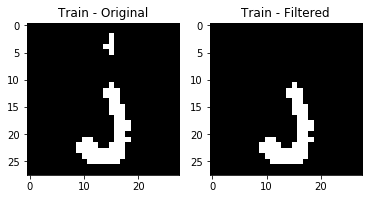

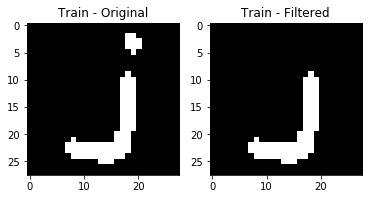

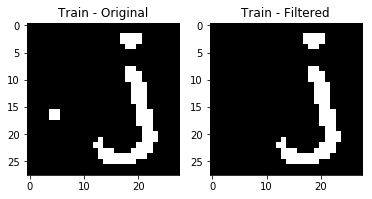

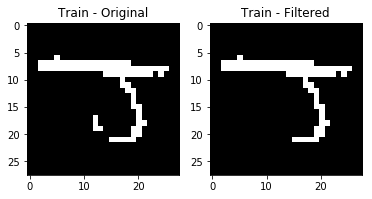

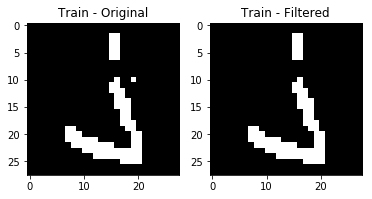

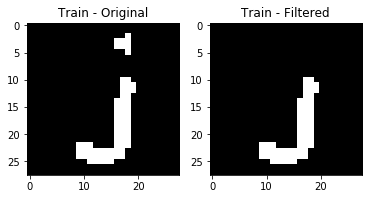

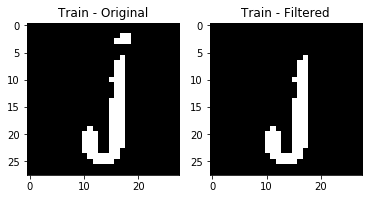

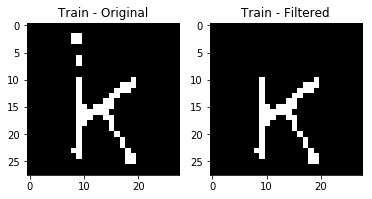

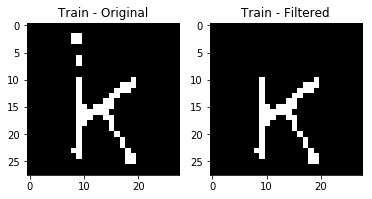

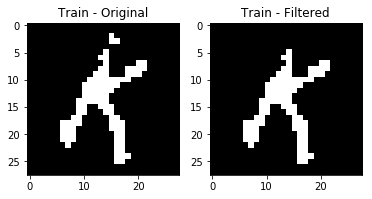

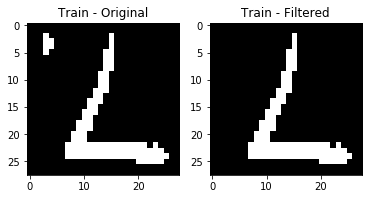

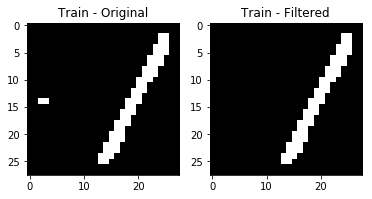

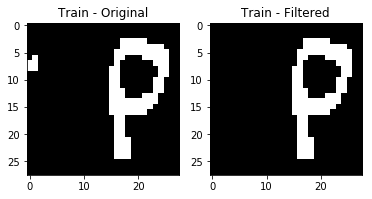

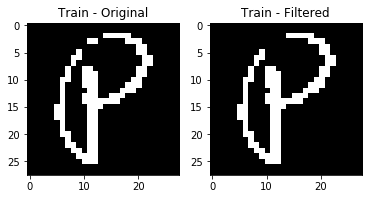

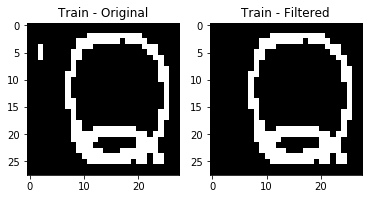

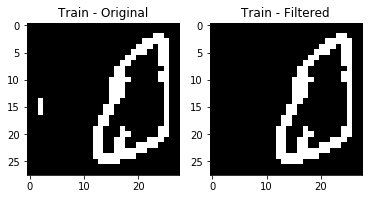

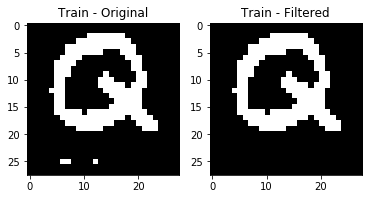

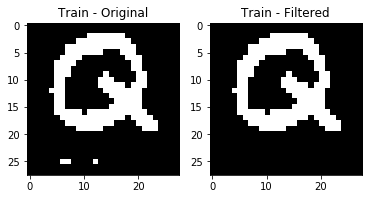

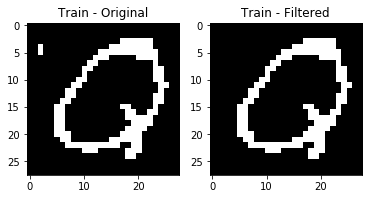

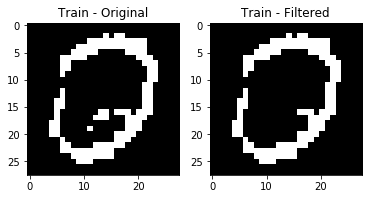

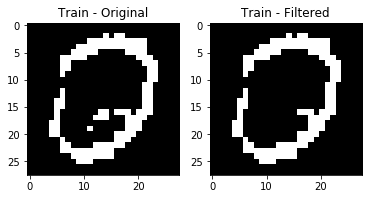

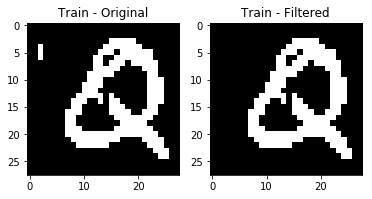

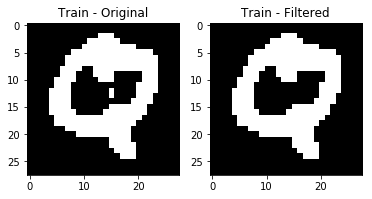

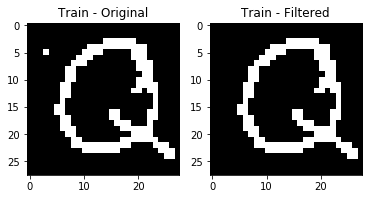

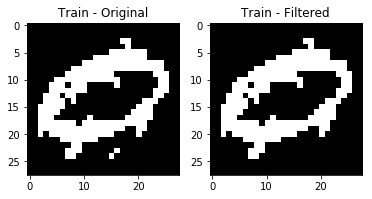

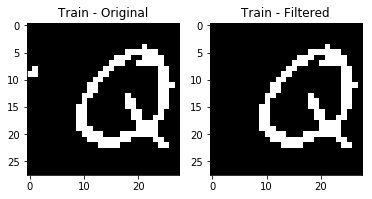

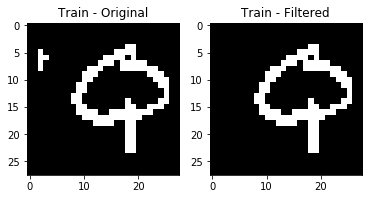

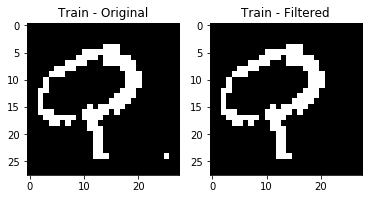

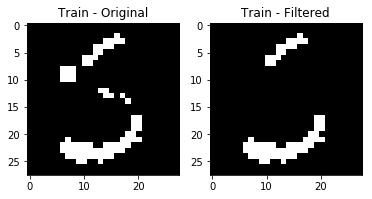

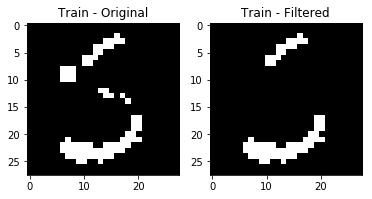

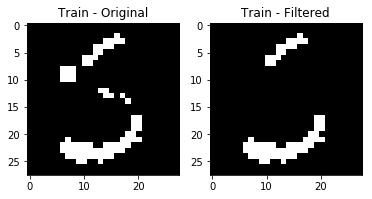

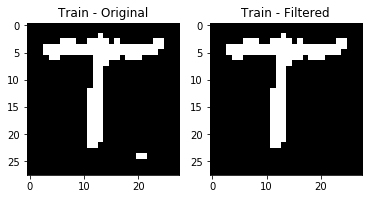

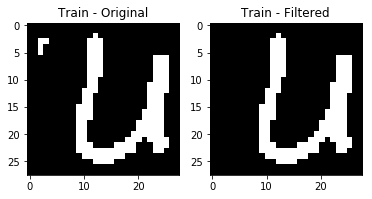

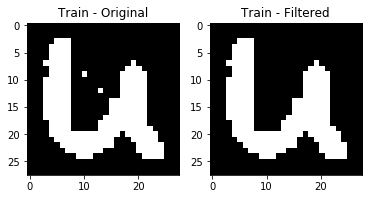

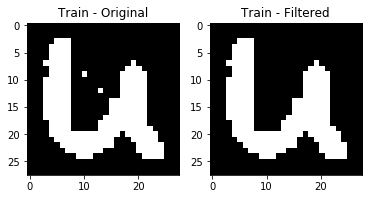

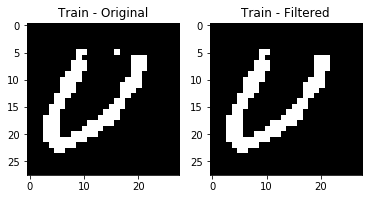

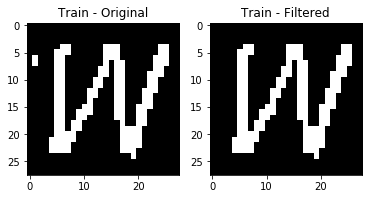

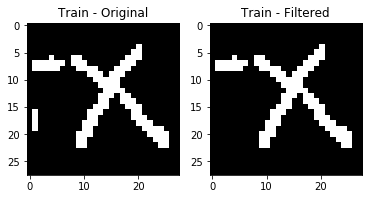

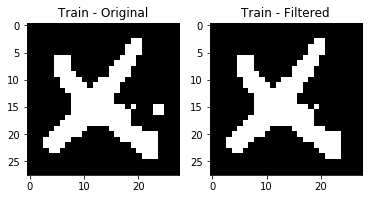

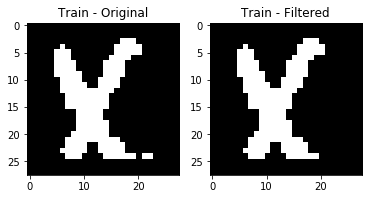

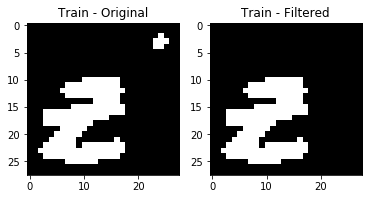

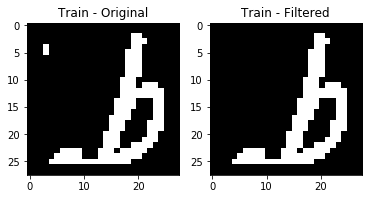

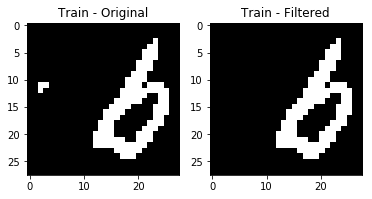

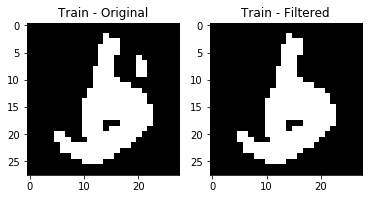

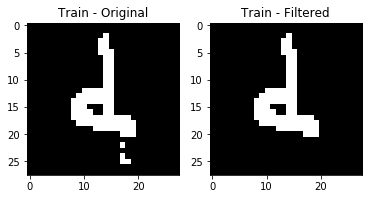

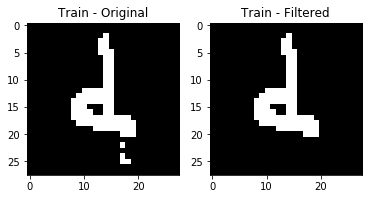

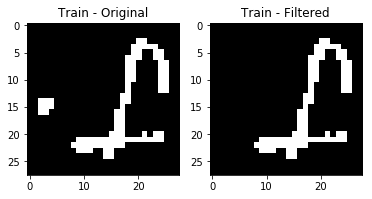

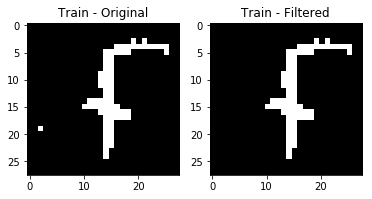

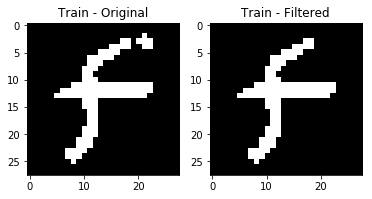

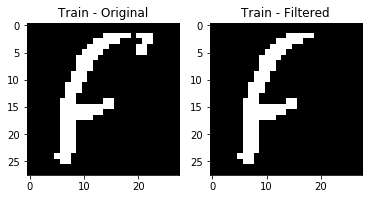

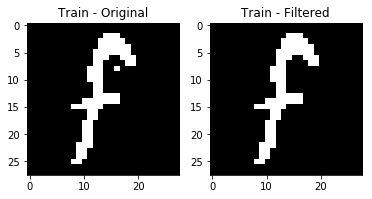

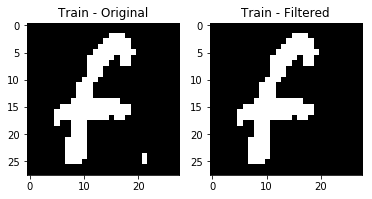

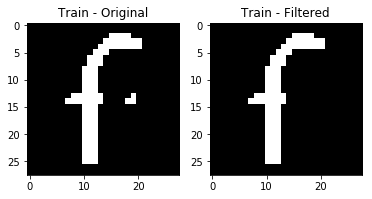

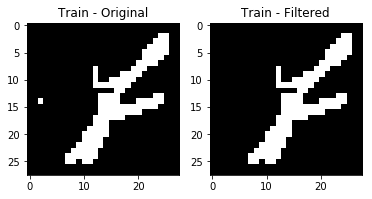

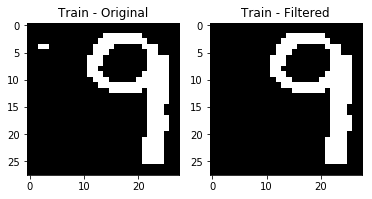

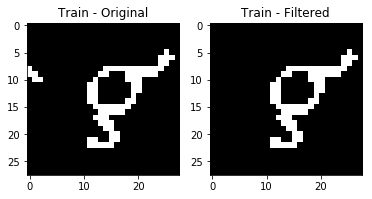

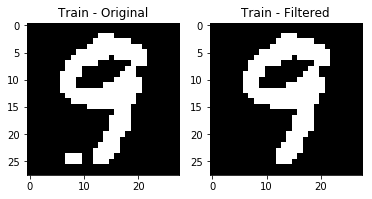

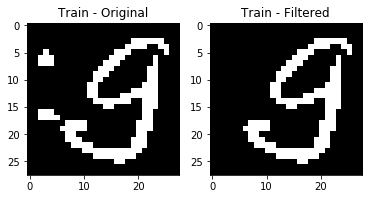

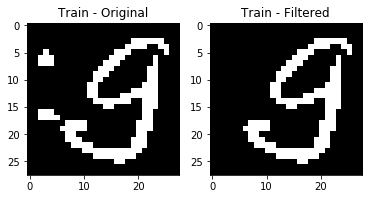

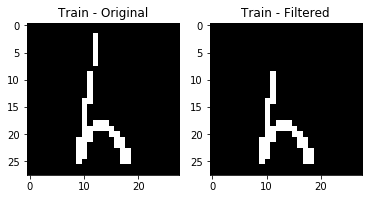

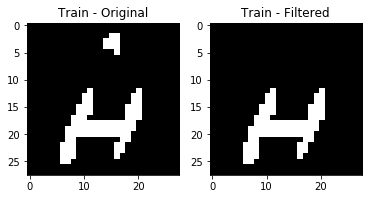

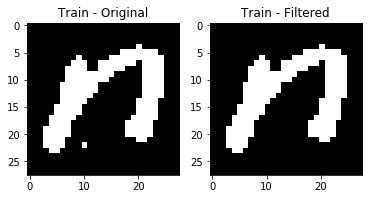

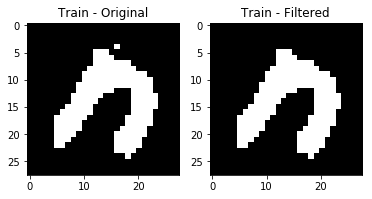

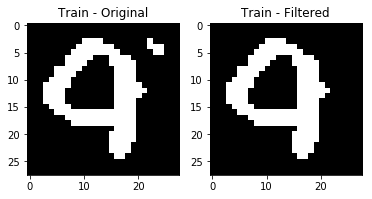

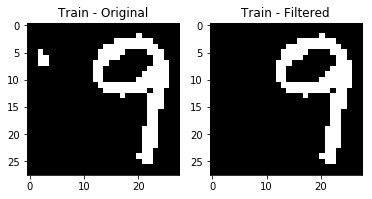

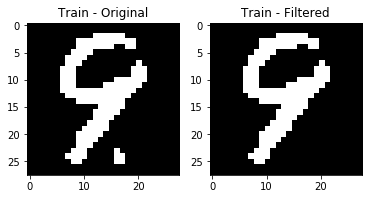

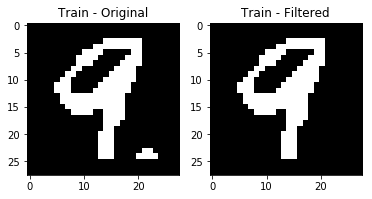

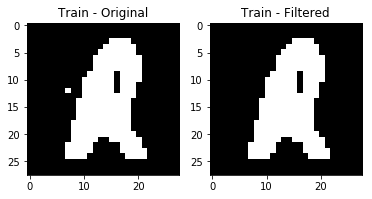

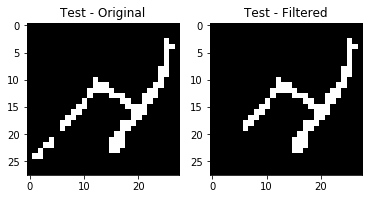

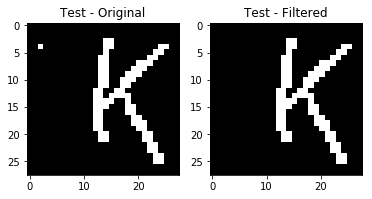

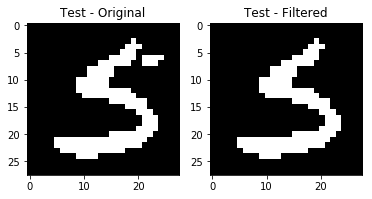

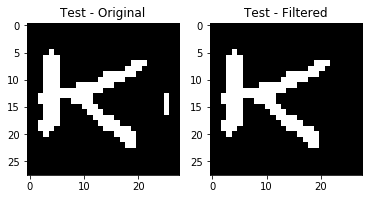

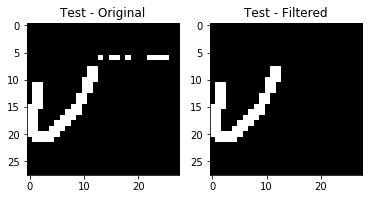

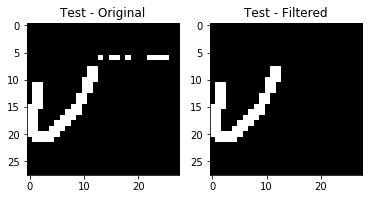

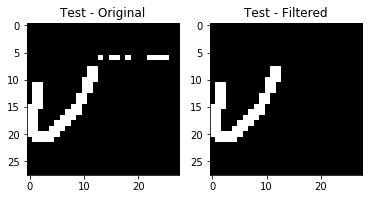

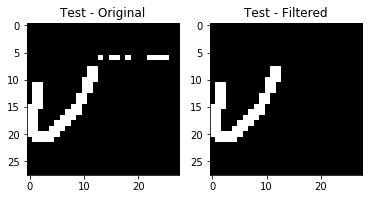

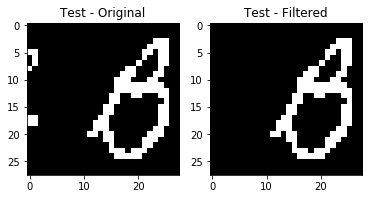

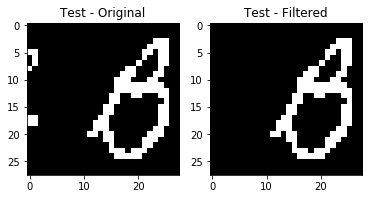

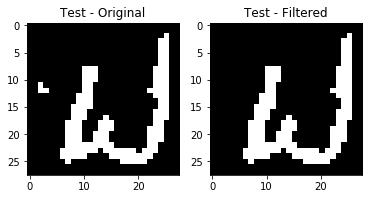

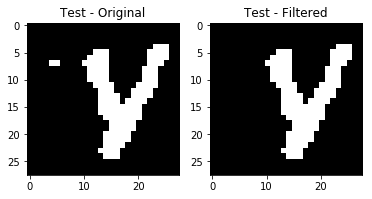

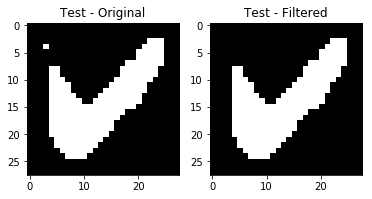

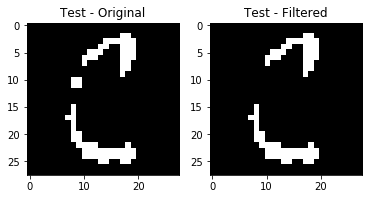

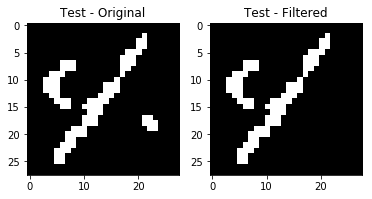

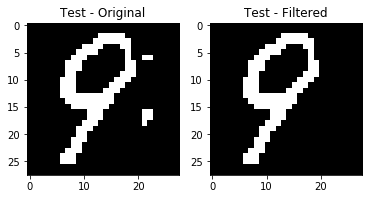

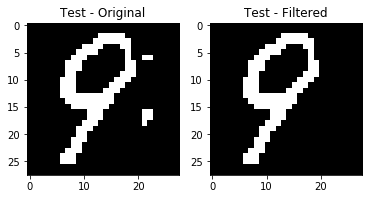

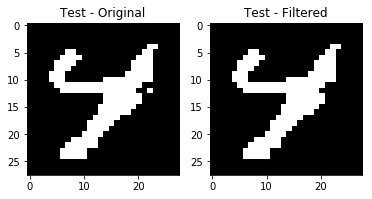

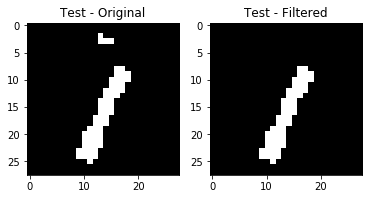

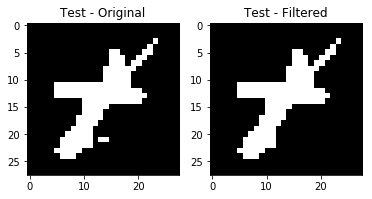

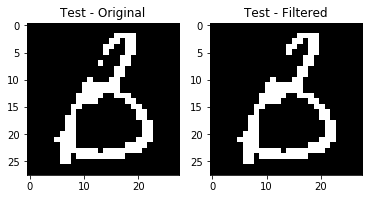

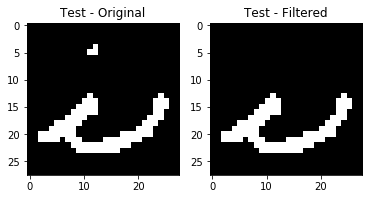

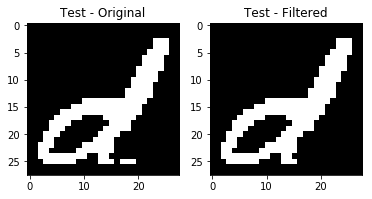

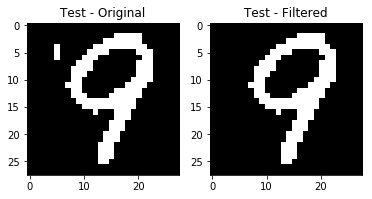

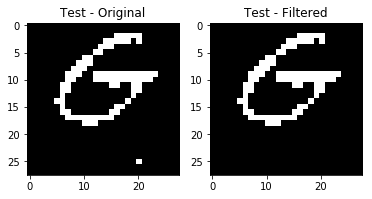

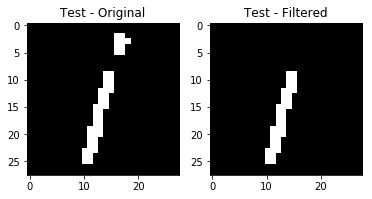

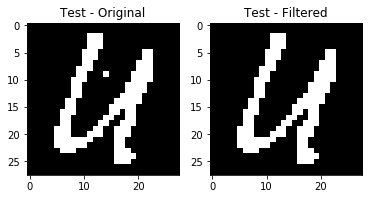

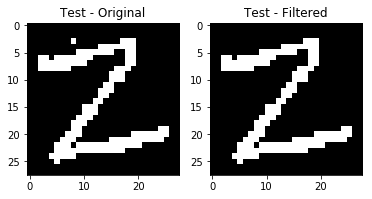

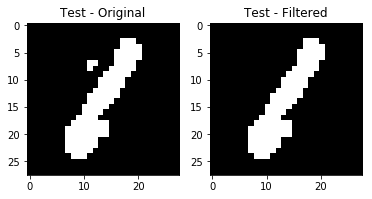

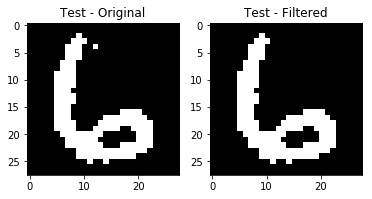

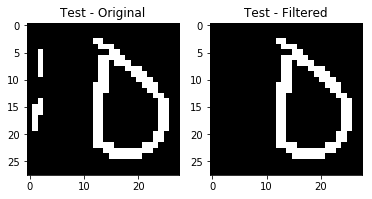

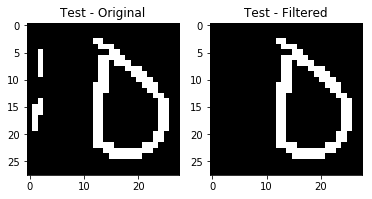

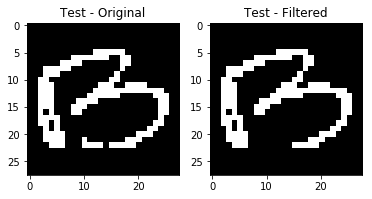

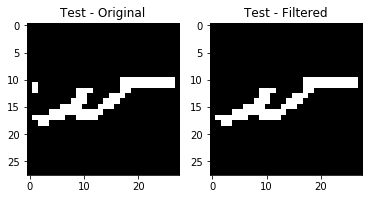

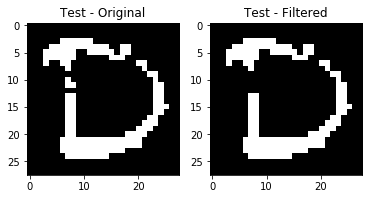

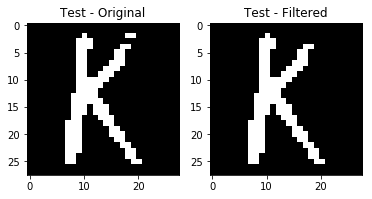

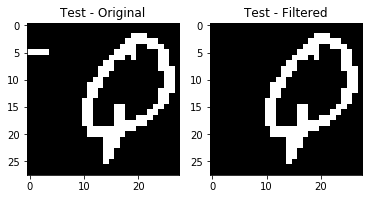

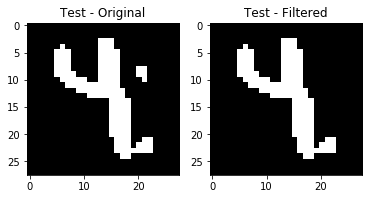

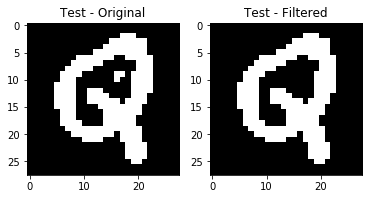

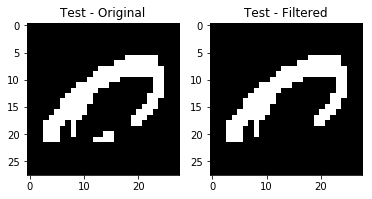

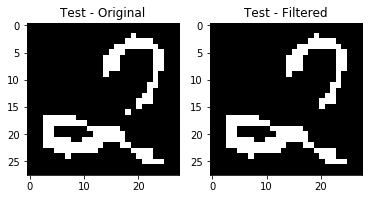

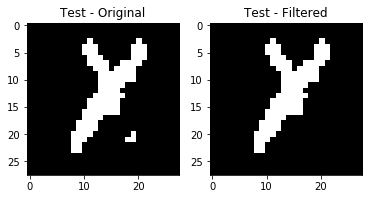

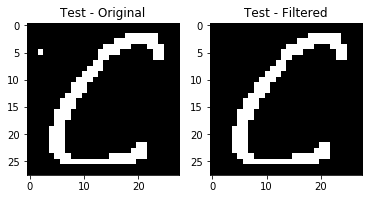

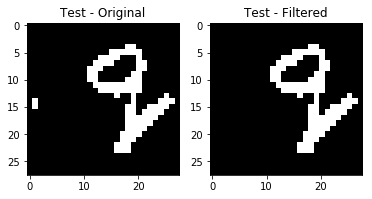

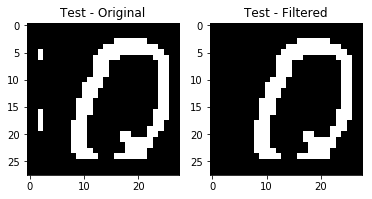

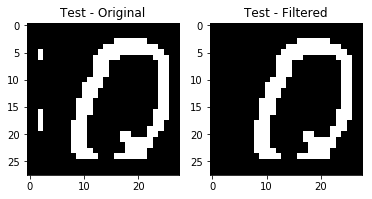

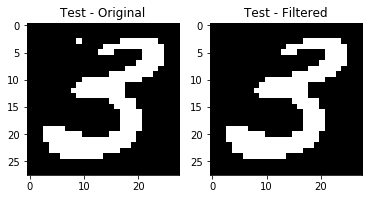

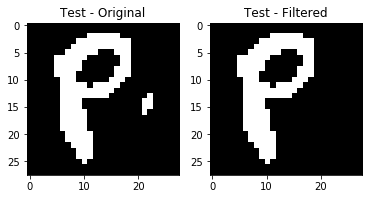

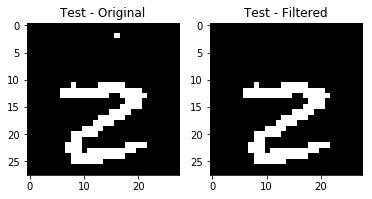

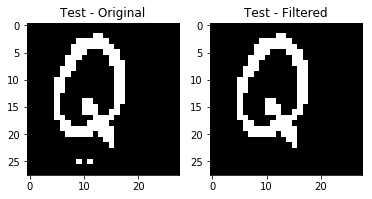

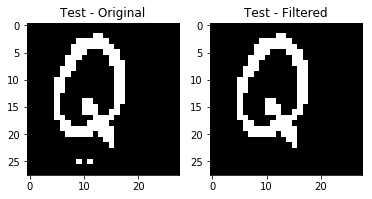

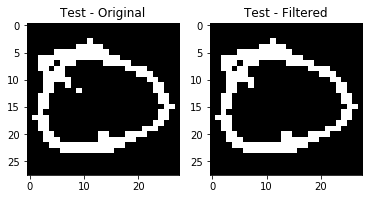

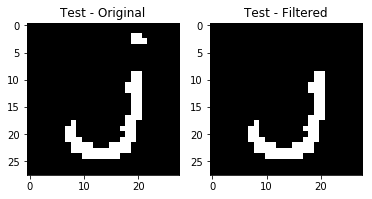

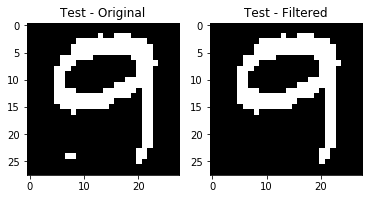

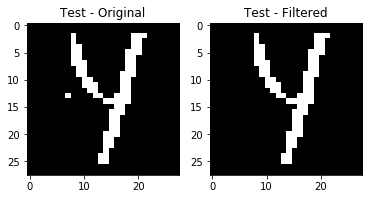

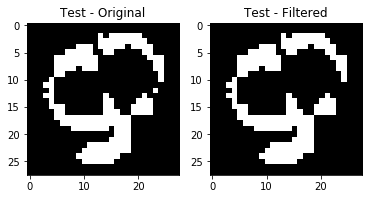

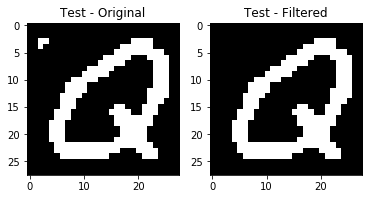

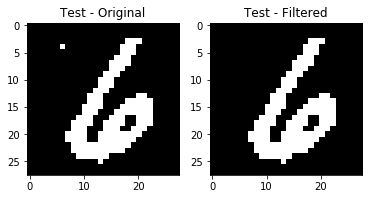

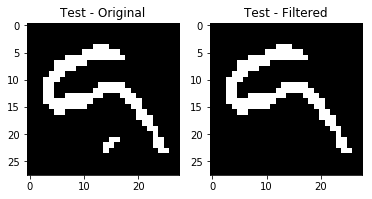

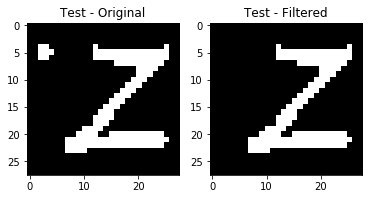

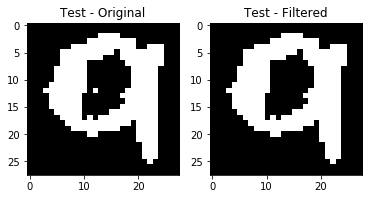

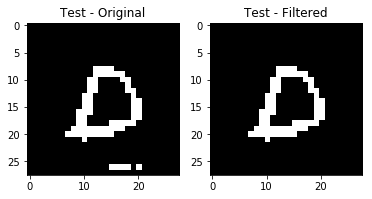

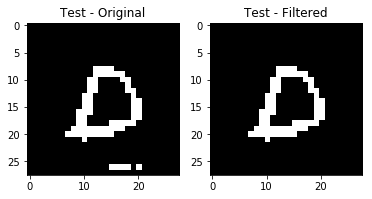

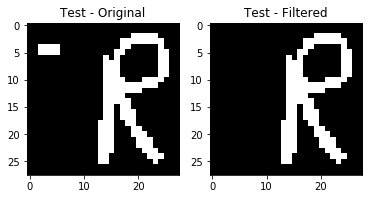

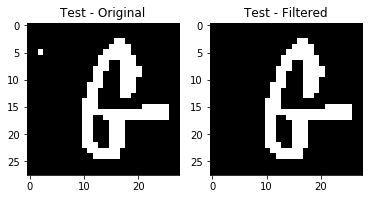

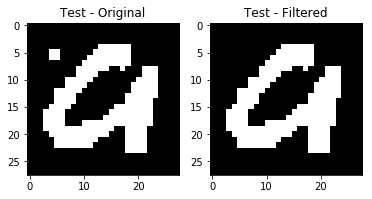

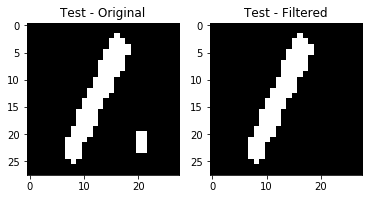

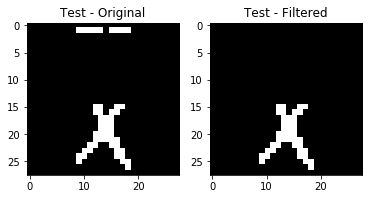

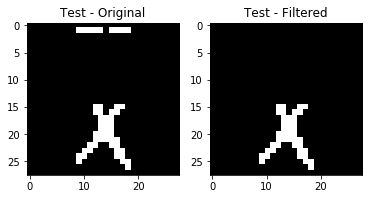

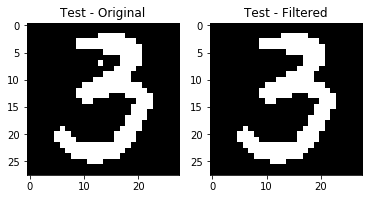

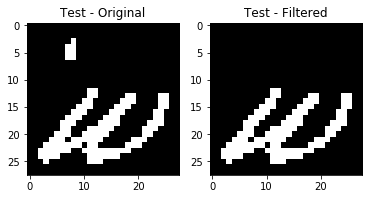

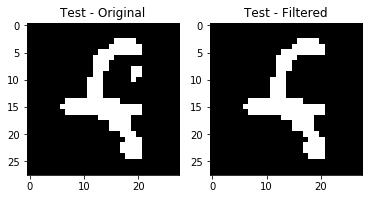

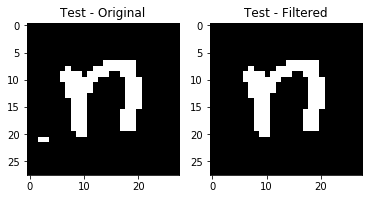

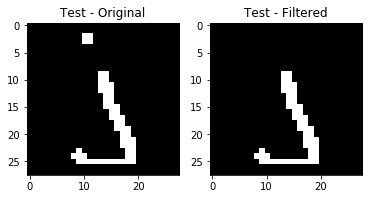

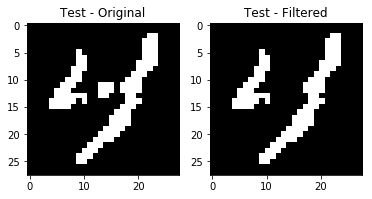

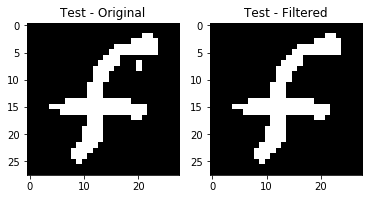

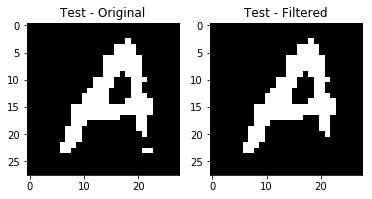

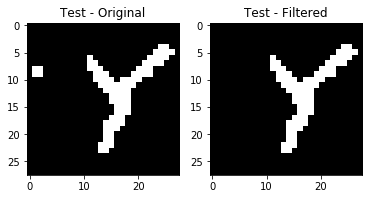

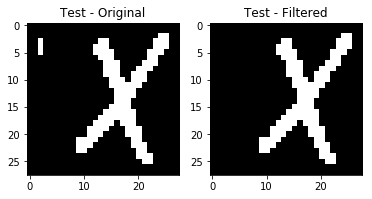

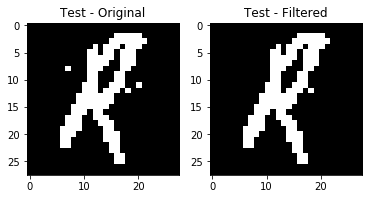

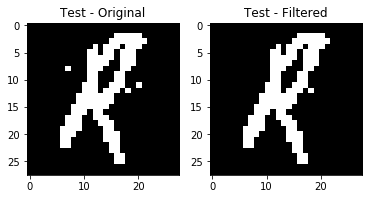

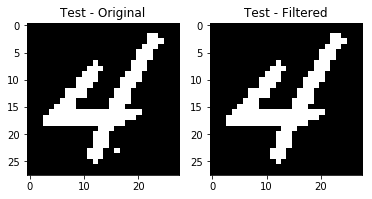

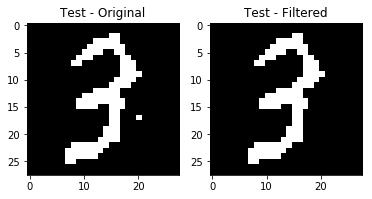

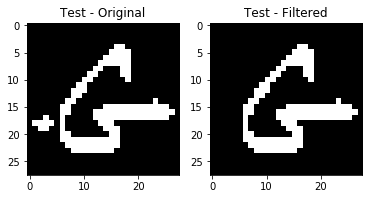

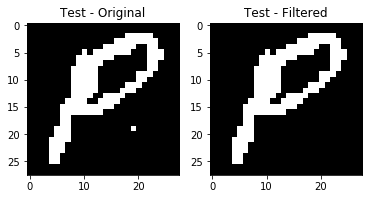

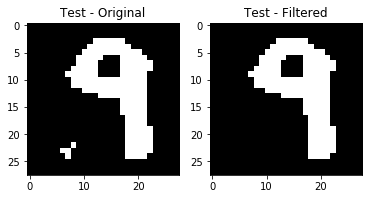

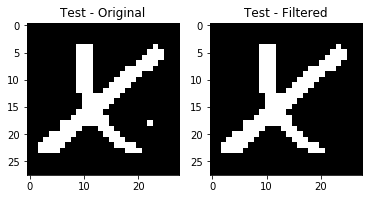

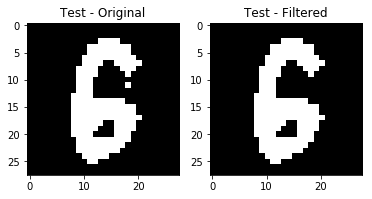

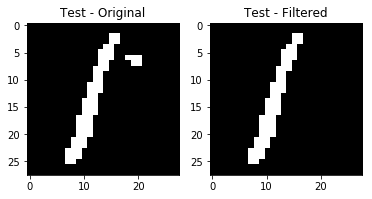

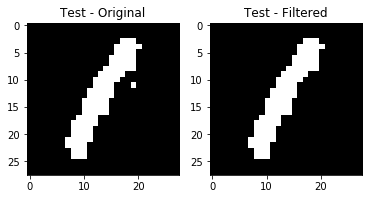

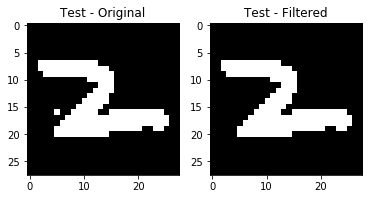

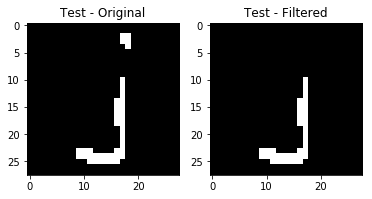

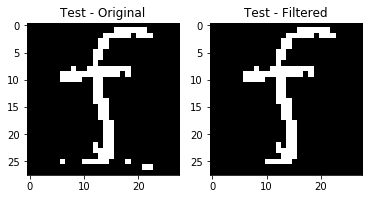

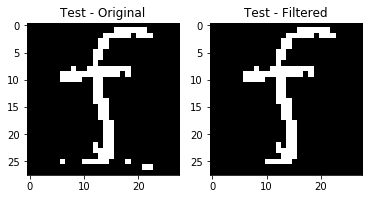

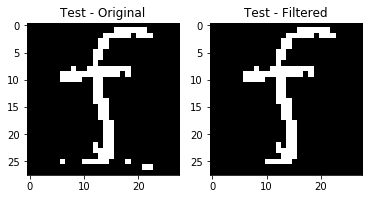

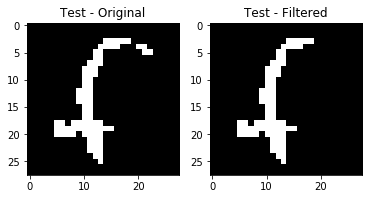

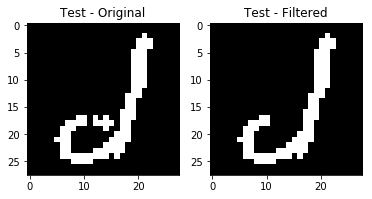

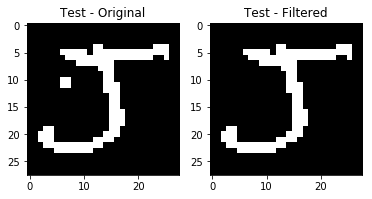

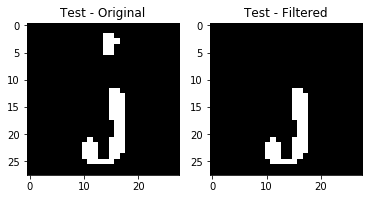

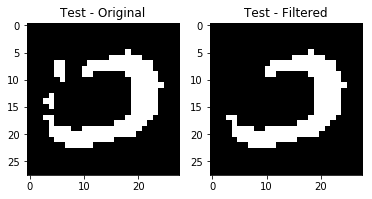

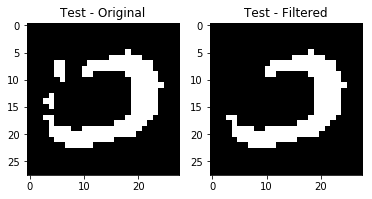

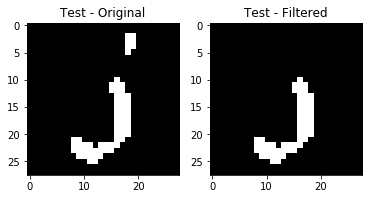

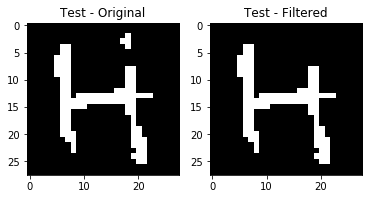

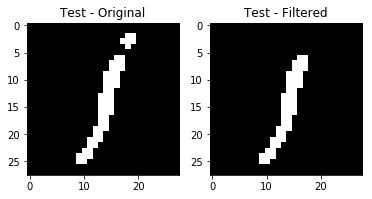

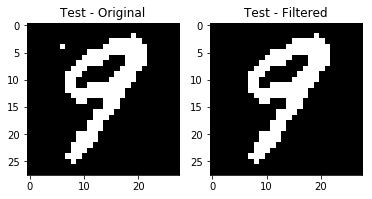

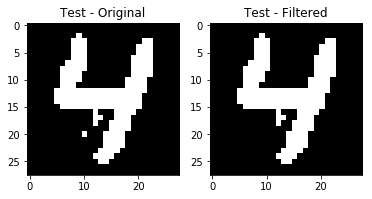

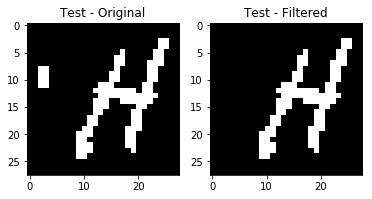

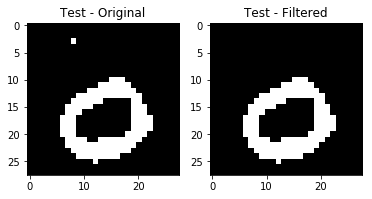

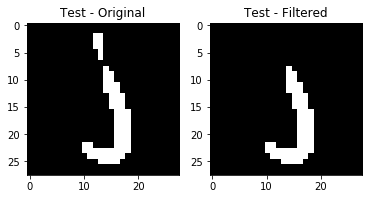

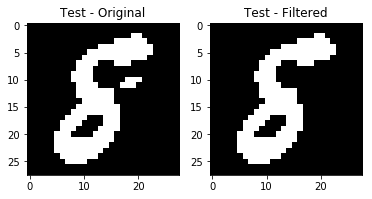

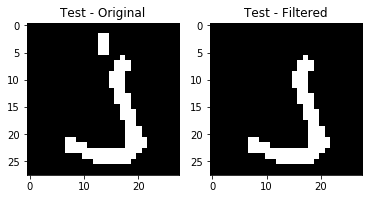

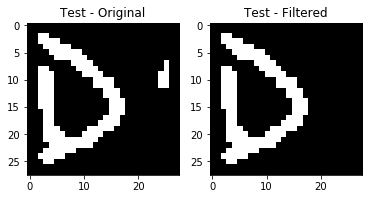

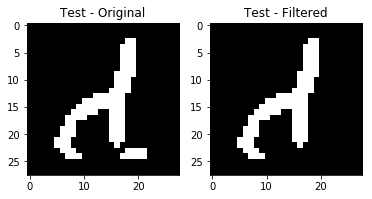

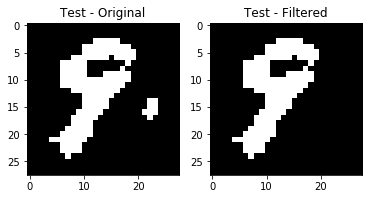

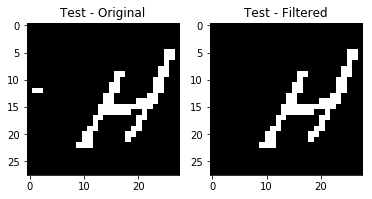

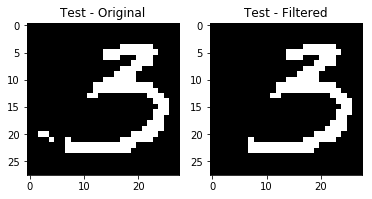

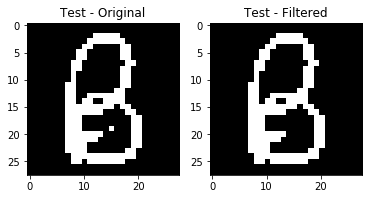

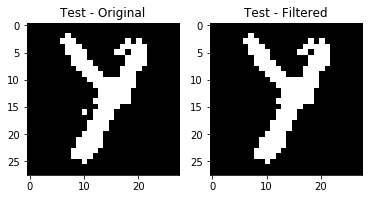

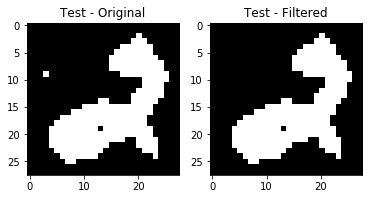

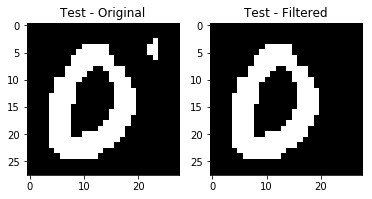

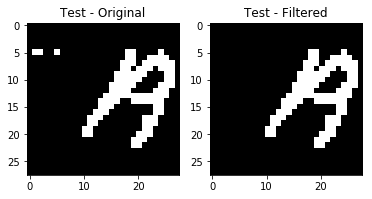

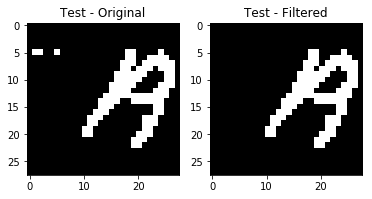

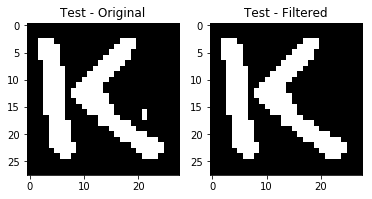

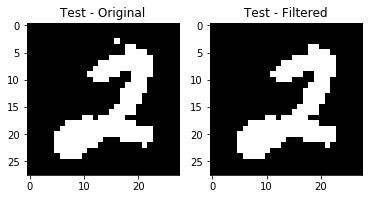

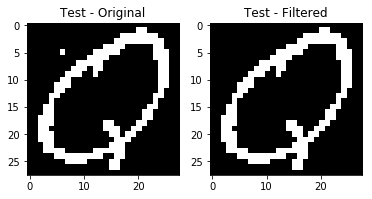

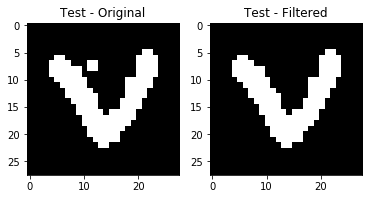

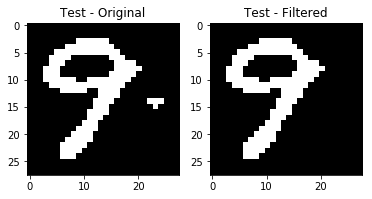

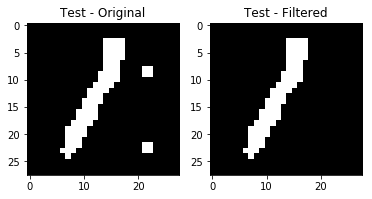

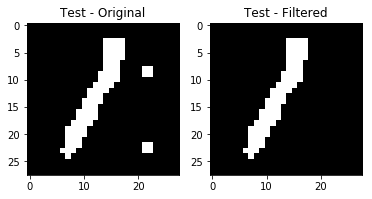

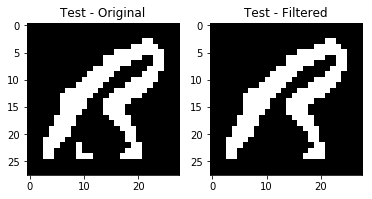

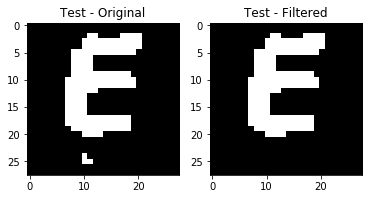

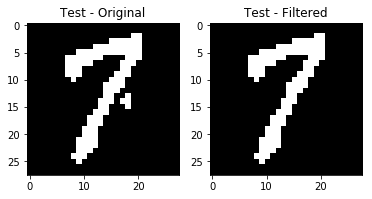

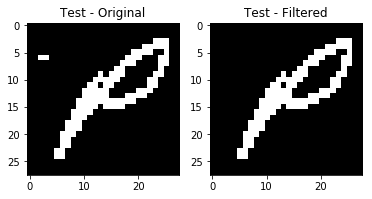

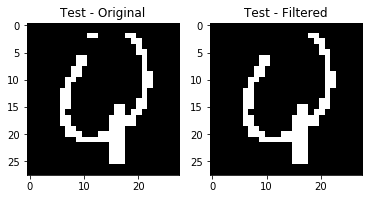

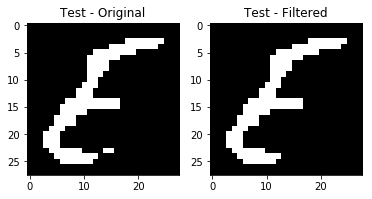

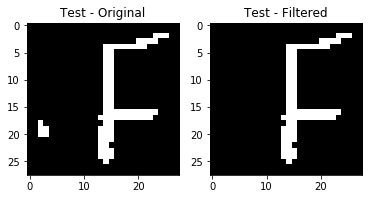

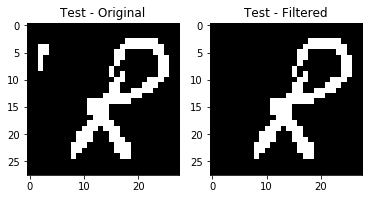

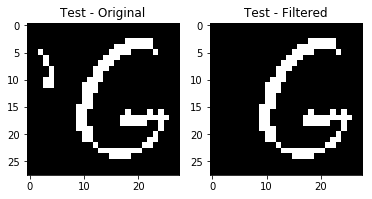

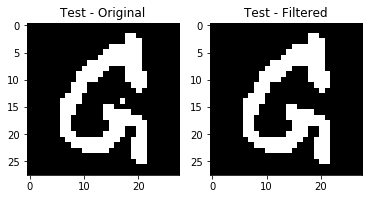

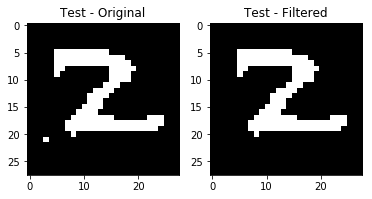

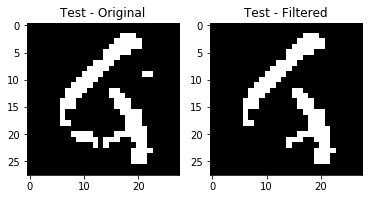

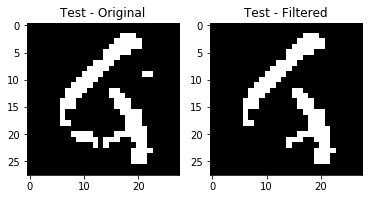

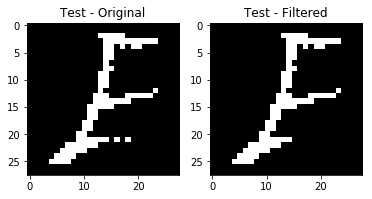

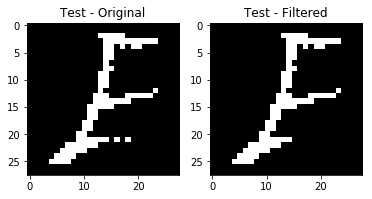

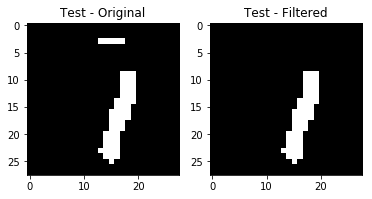

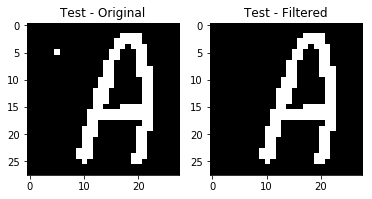

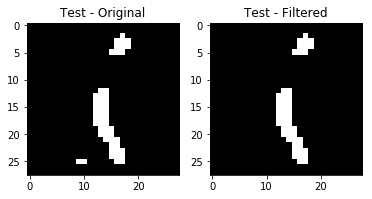

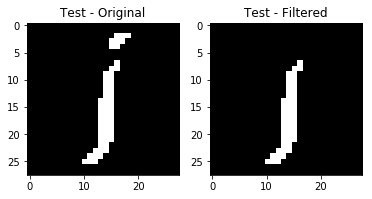

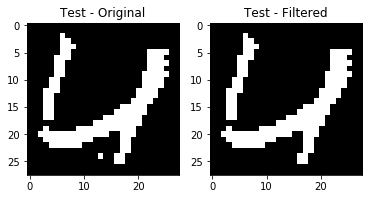

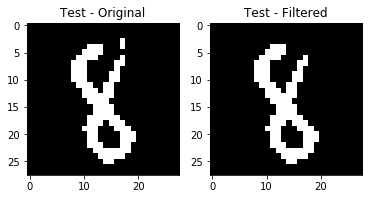

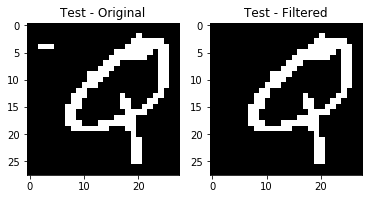

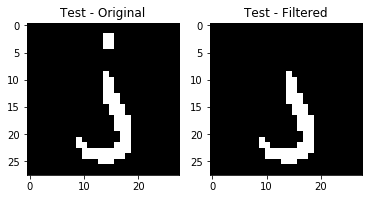

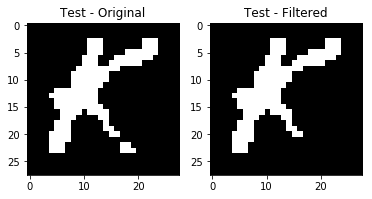

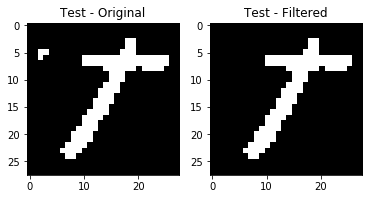

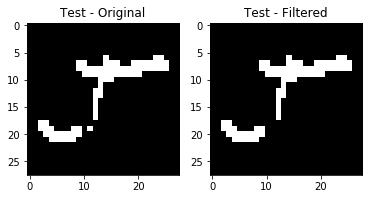

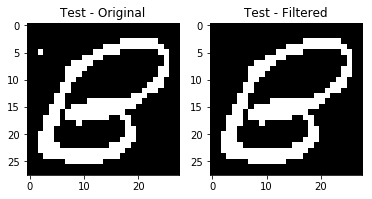

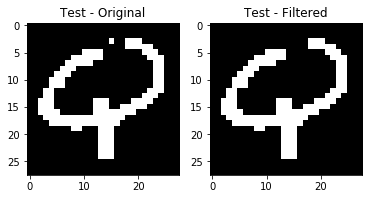

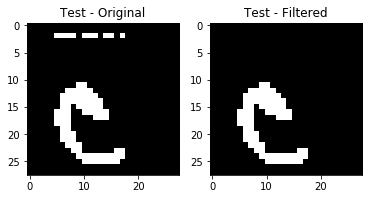

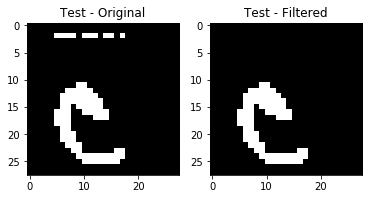

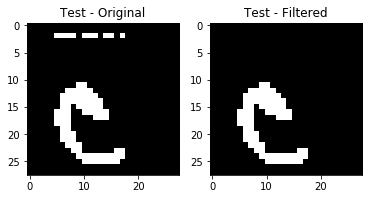

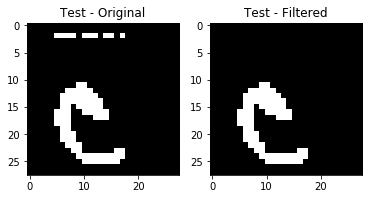

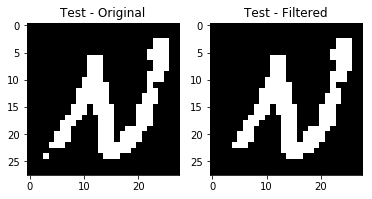

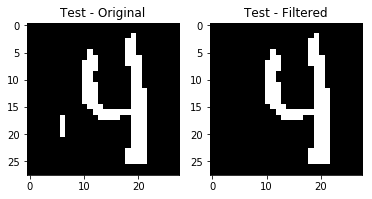

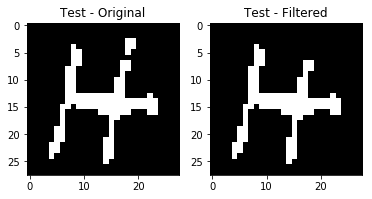

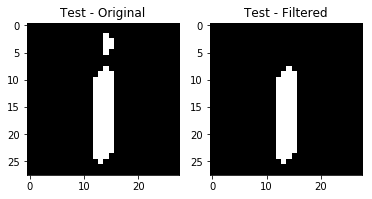

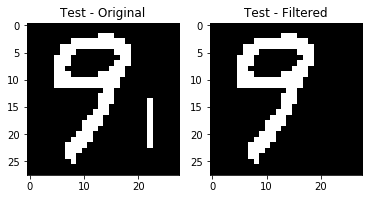

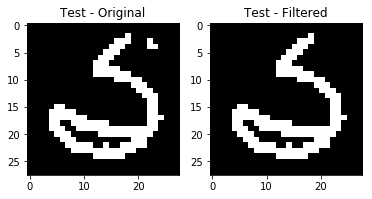

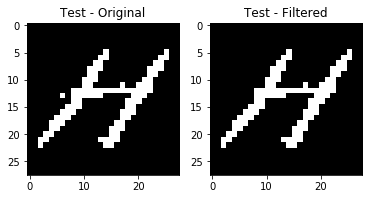

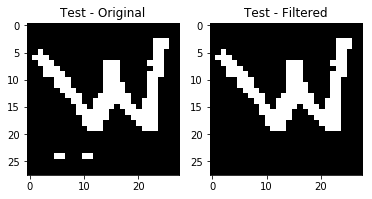

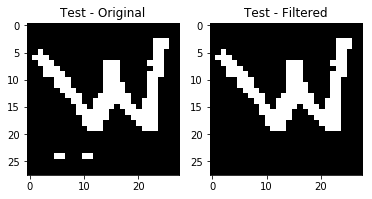

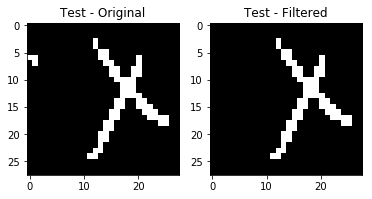

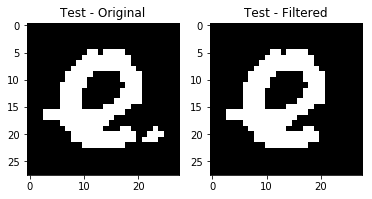

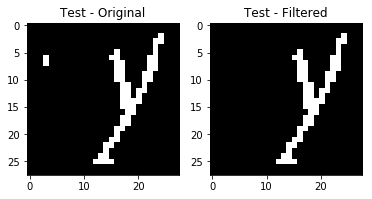

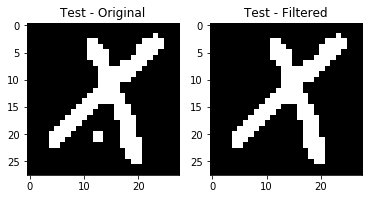

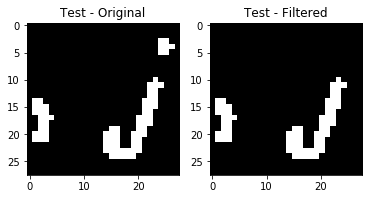

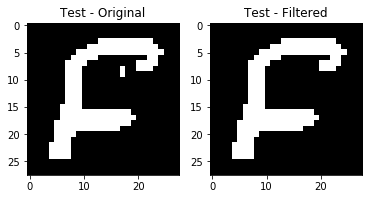

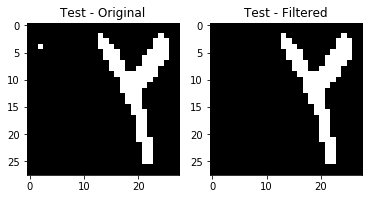

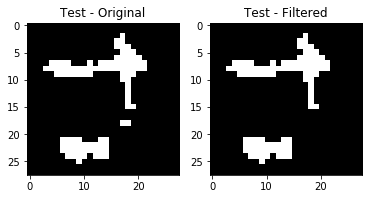

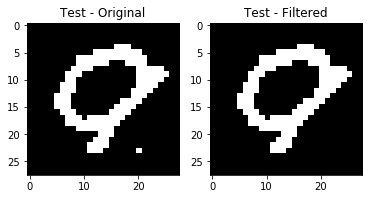

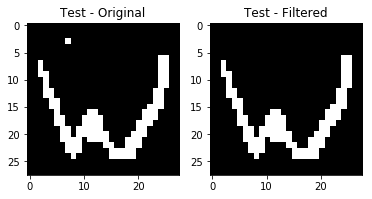

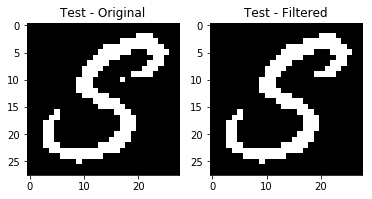

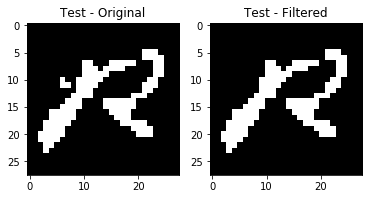

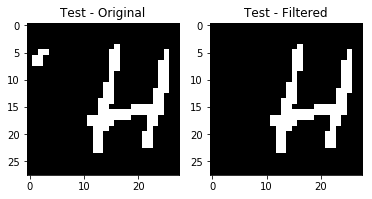

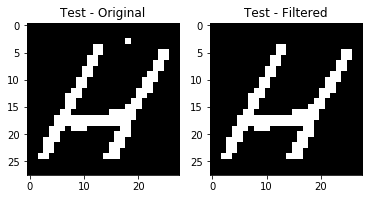

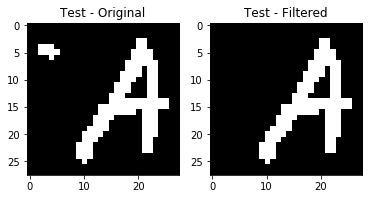

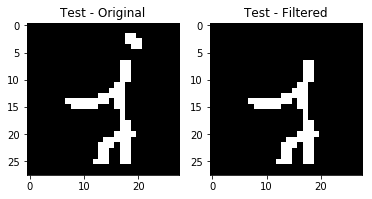

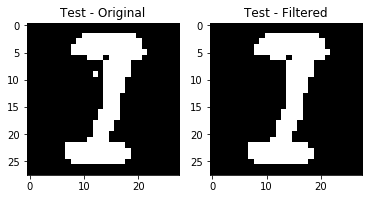

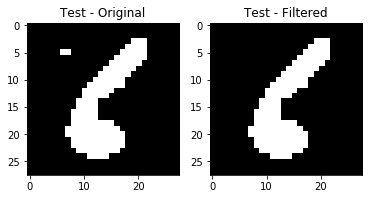

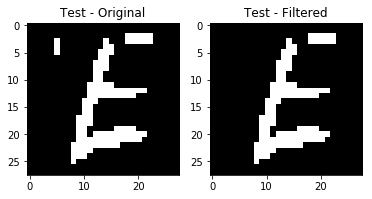

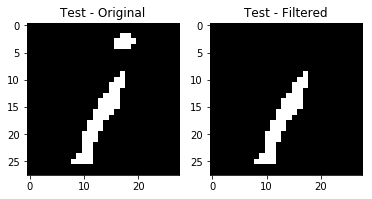

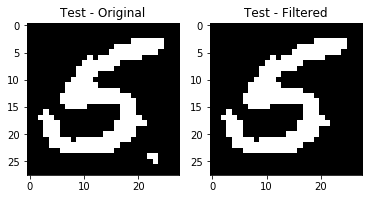

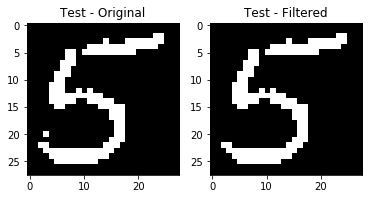

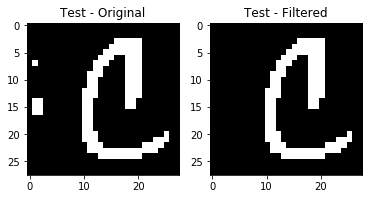

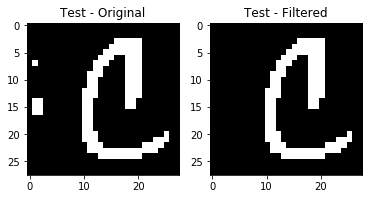

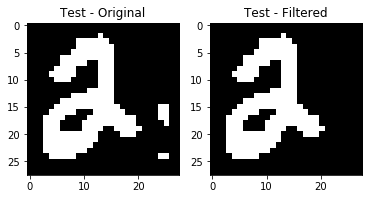

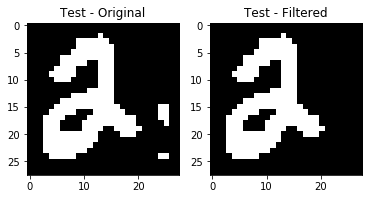

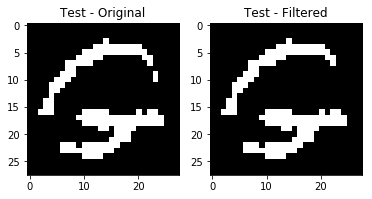

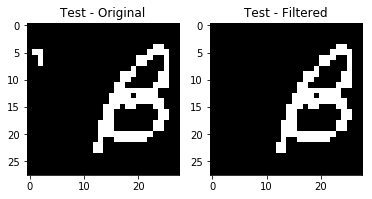

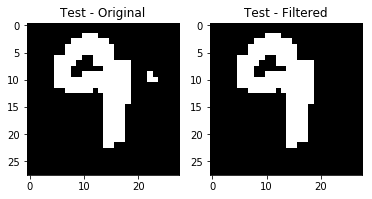

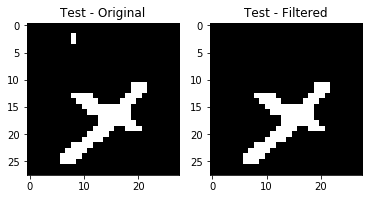

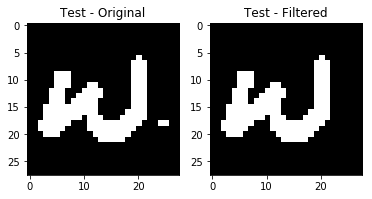

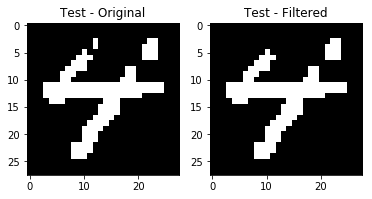

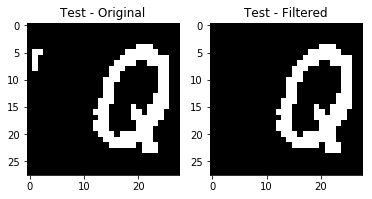

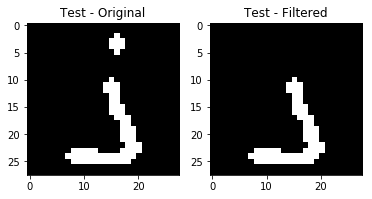

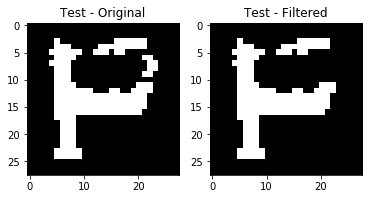

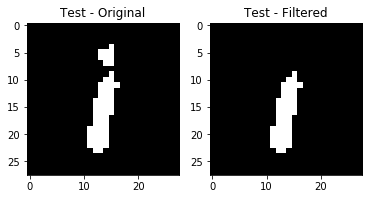

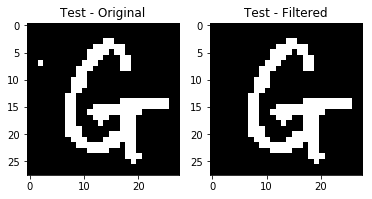

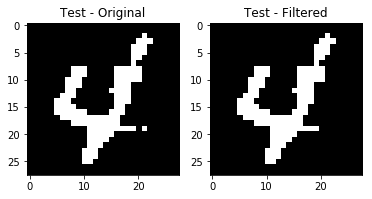

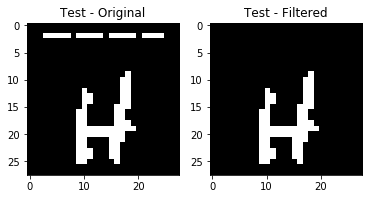

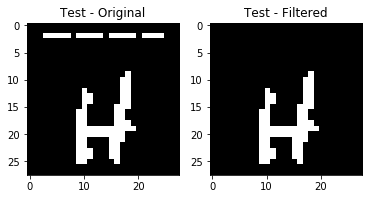

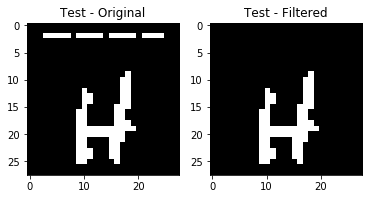

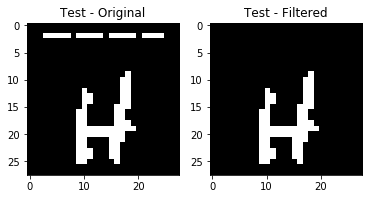

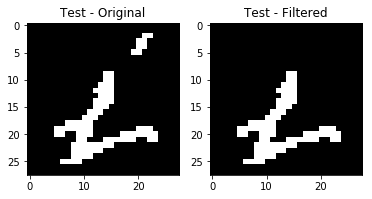

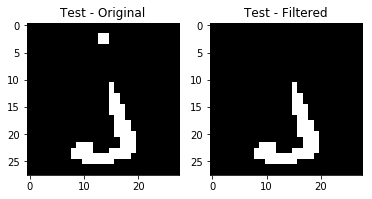

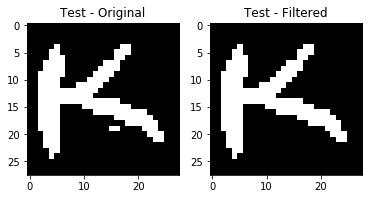

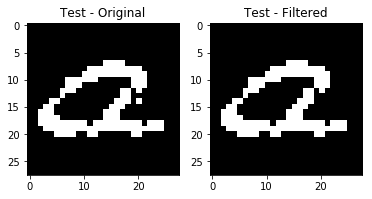

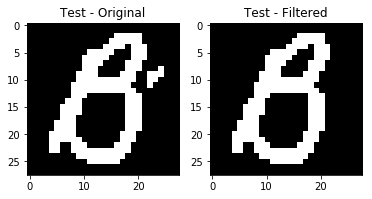

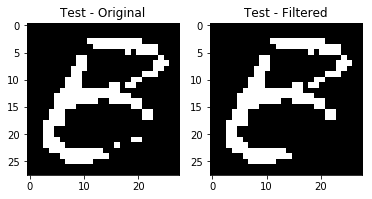

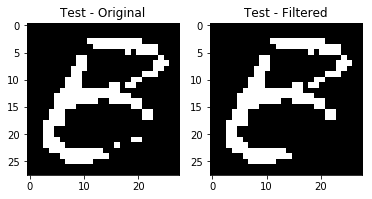

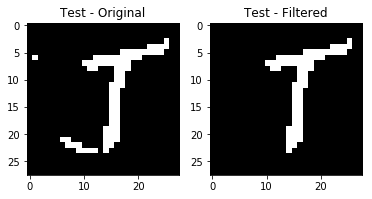

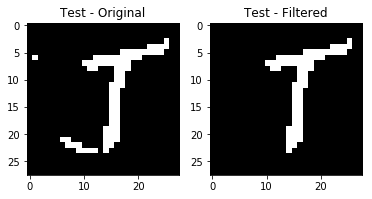

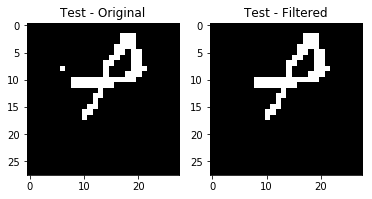

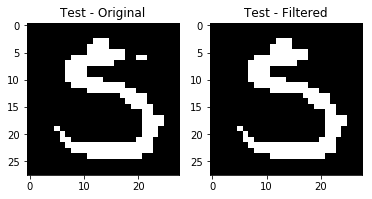

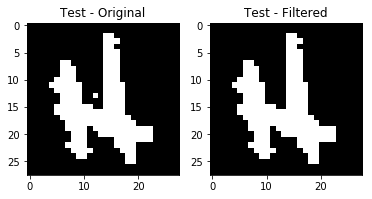

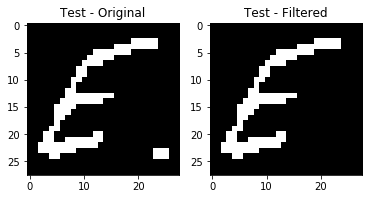

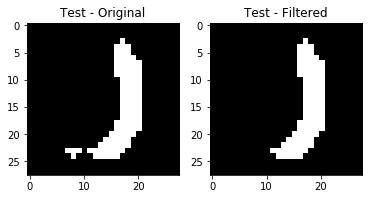

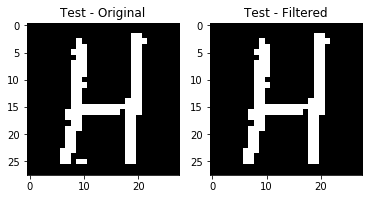

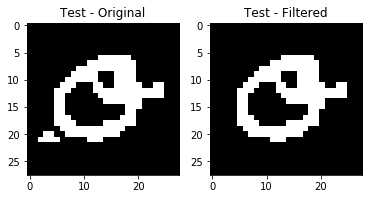

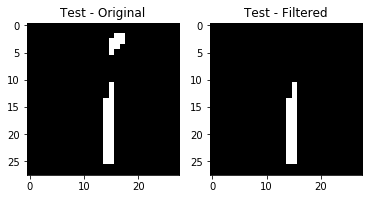

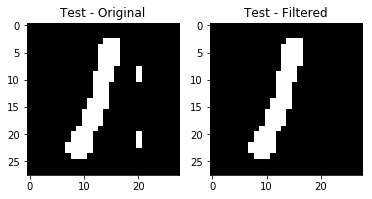

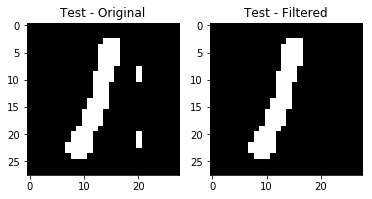

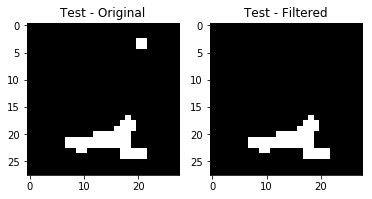

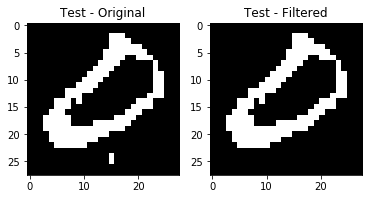

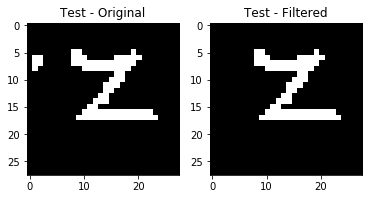

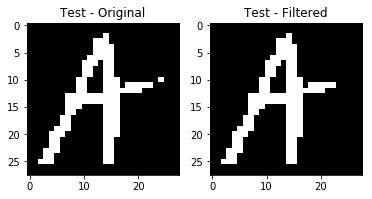

In [218]:
for i in coefs:
    plt.subplot(1, 2, 1)
    plt.imshow(X_train_otsu[i], cmap = 'gray')
    plt.title("Train - Original")
    plt.subplot(1, 2, 2)
    plt.imshow(X_train_otsu_clean[i], cmap = 'gray')
    plt.title("Train - Filtered")
    plt.show()

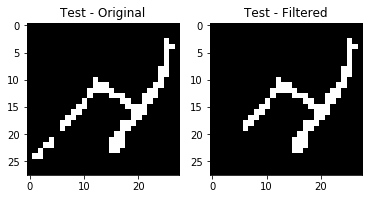

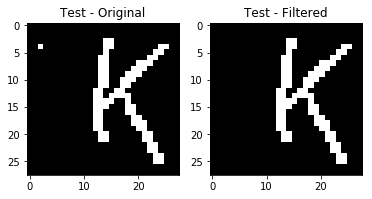

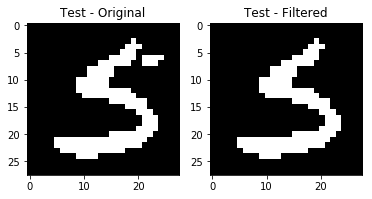

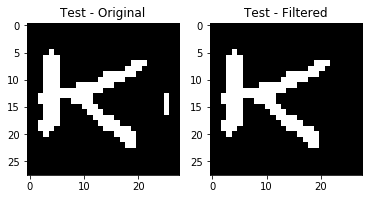

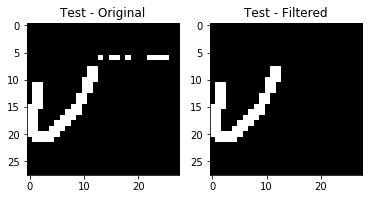

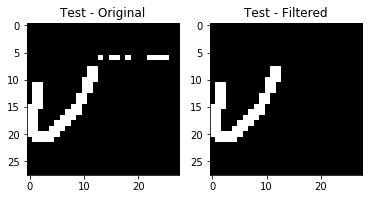

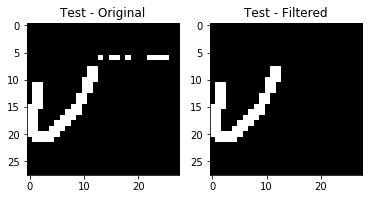

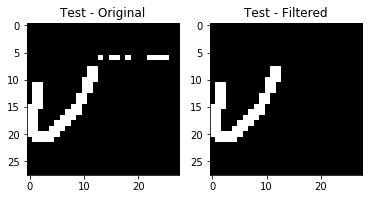

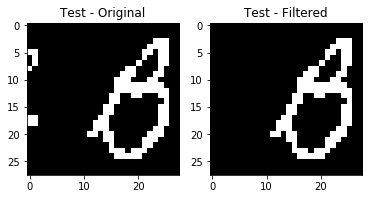

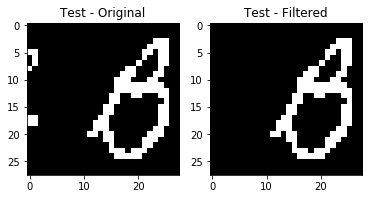

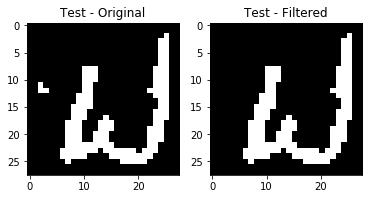

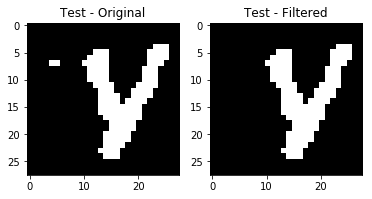

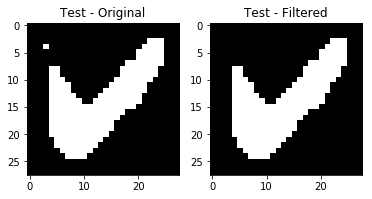

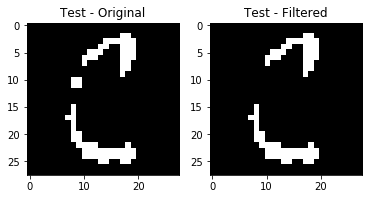

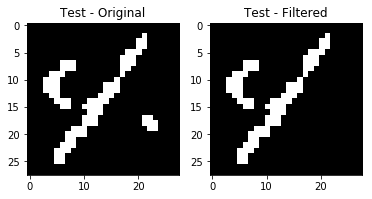

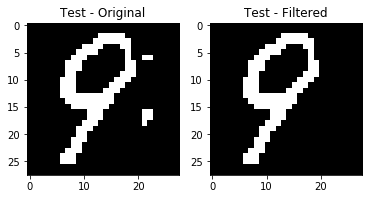

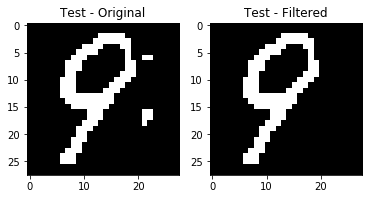

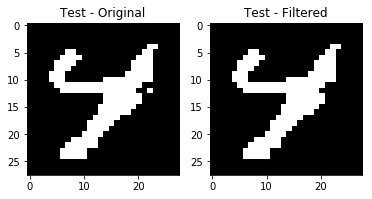

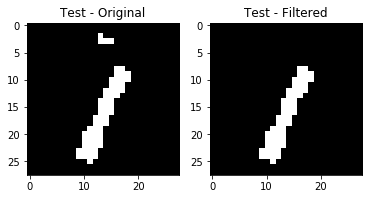

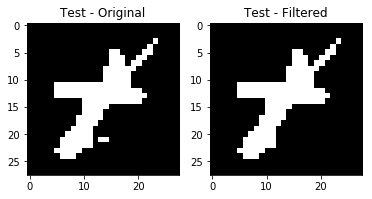

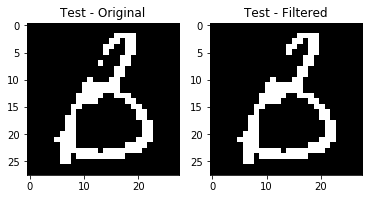

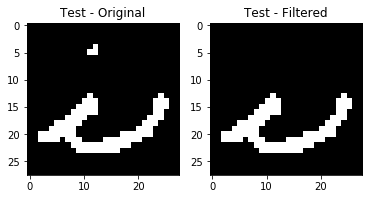

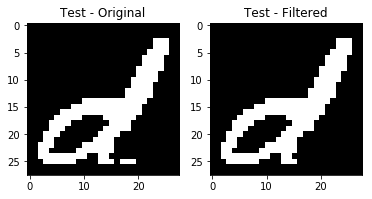

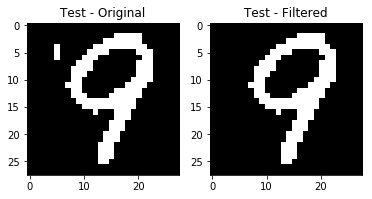

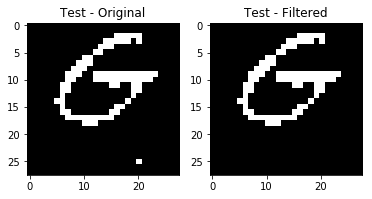

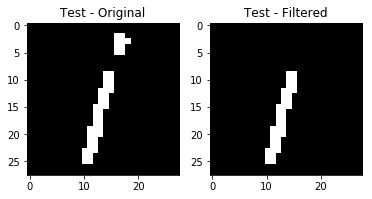

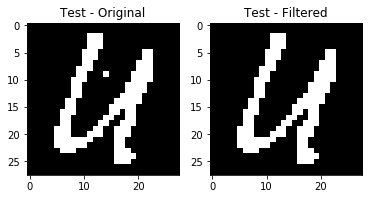

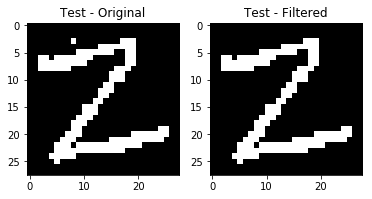

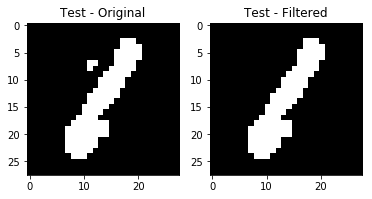

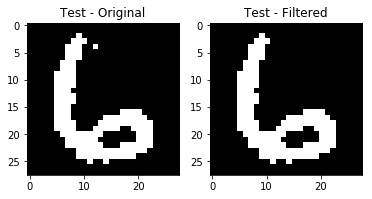

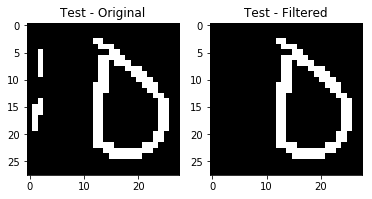

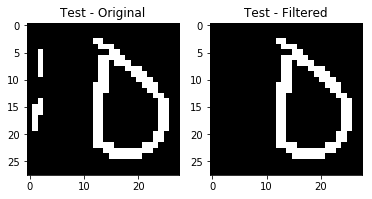

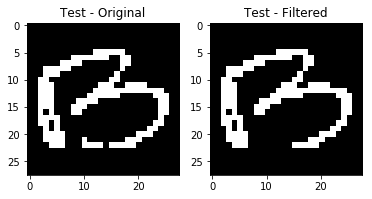

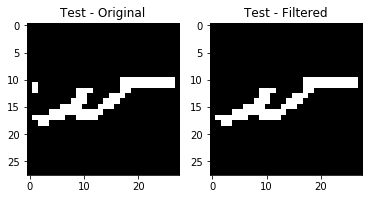

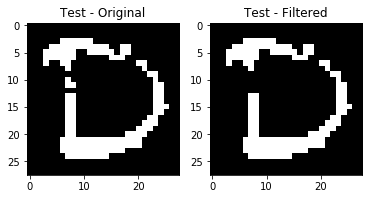

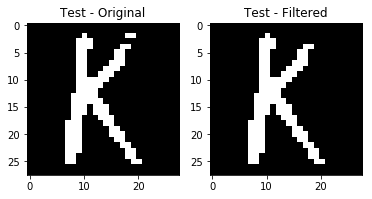

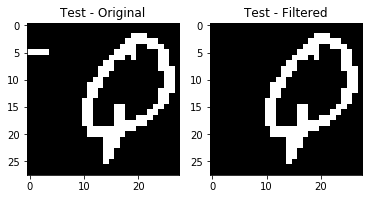

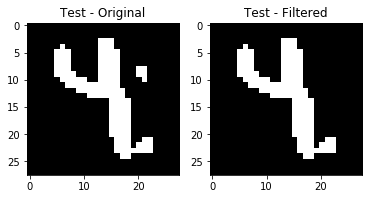

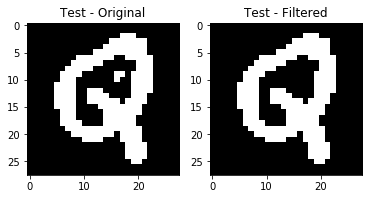

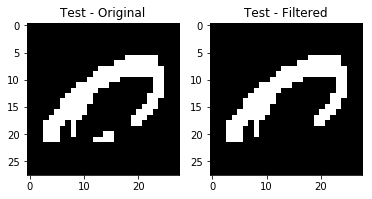

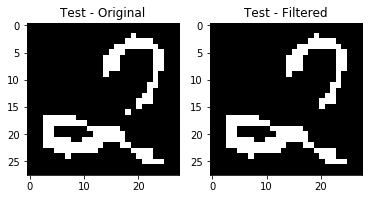

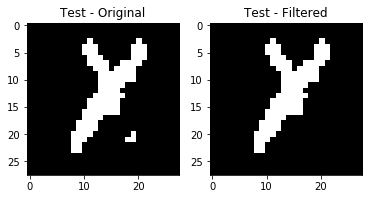

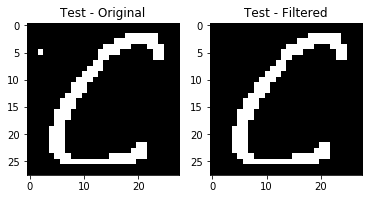

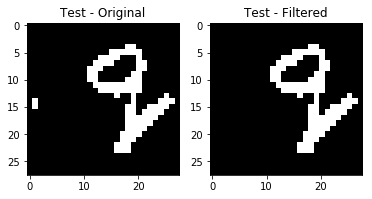

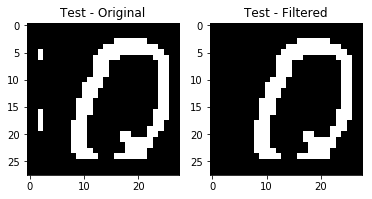

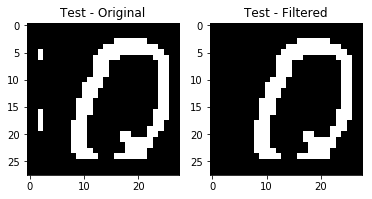

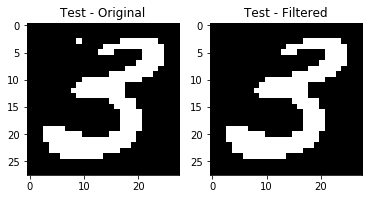

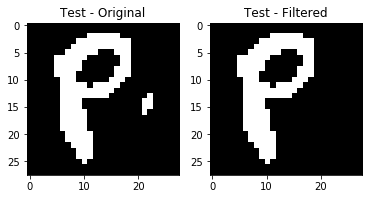

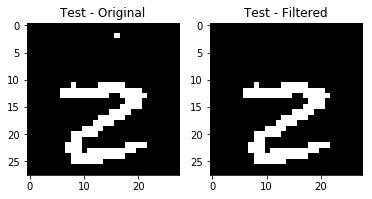

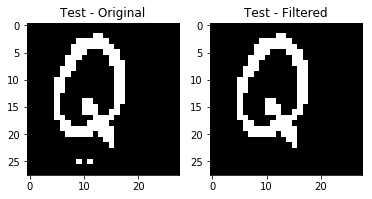

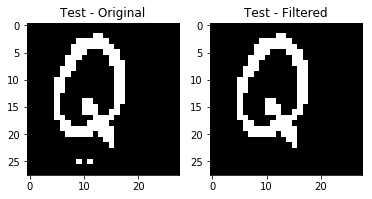

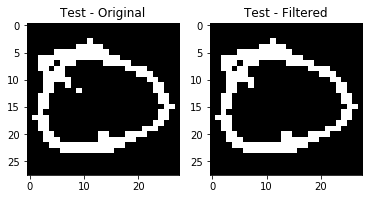

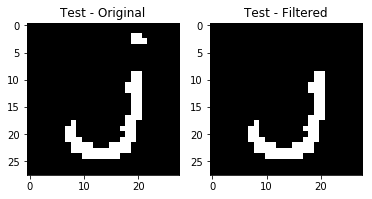

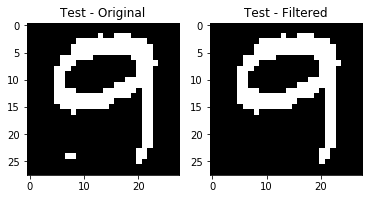

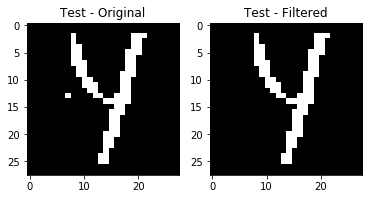

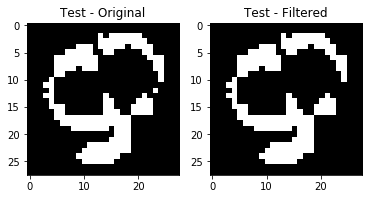

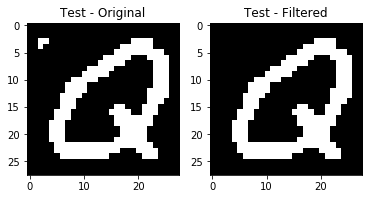

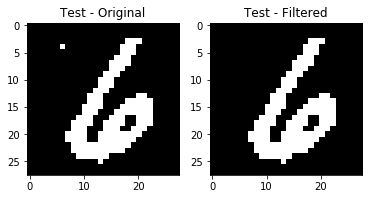

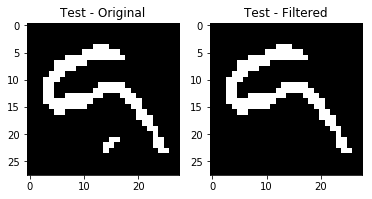

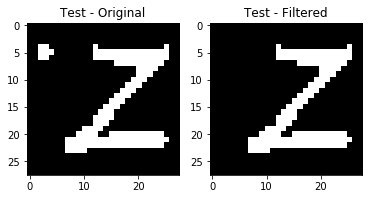

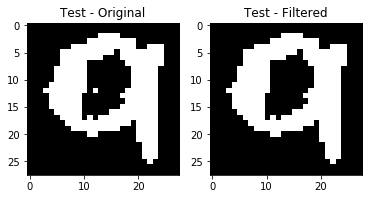

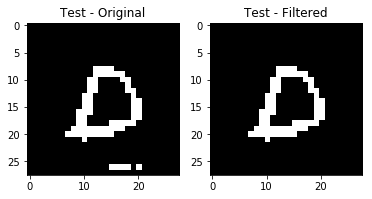

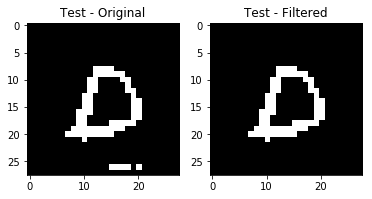

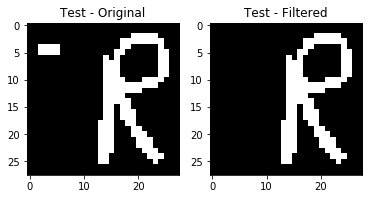

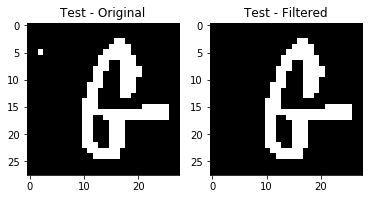

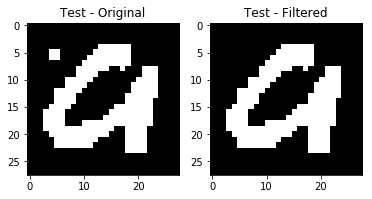

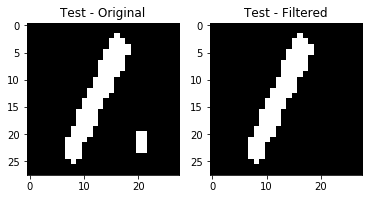

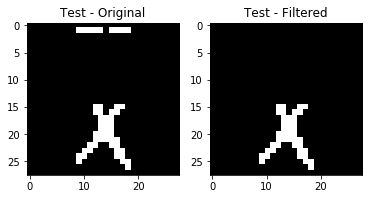

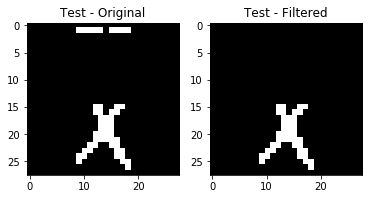

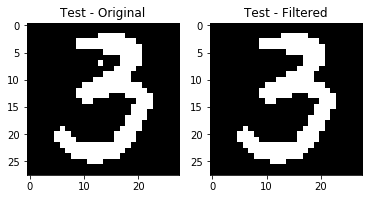

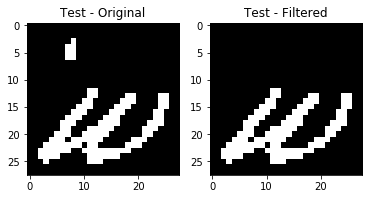

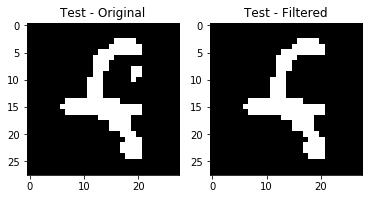

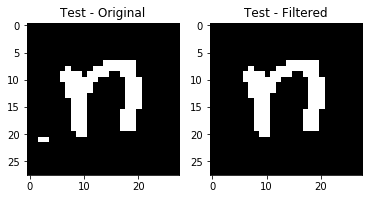

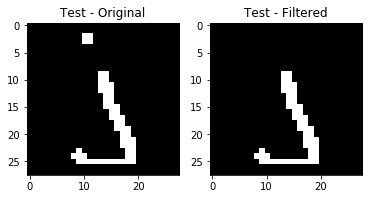

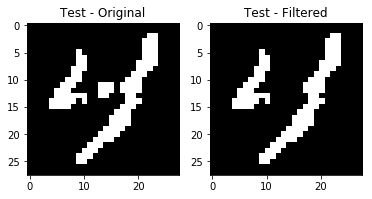

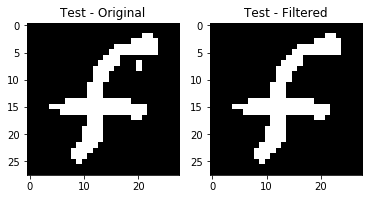

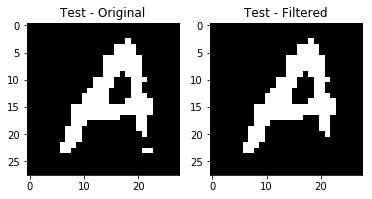

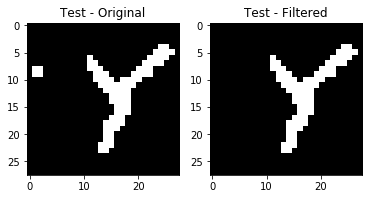

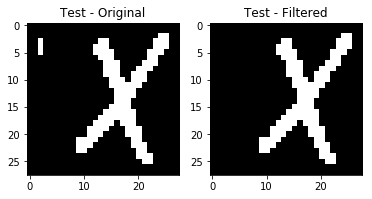

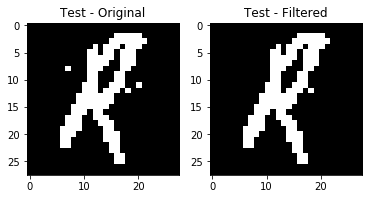

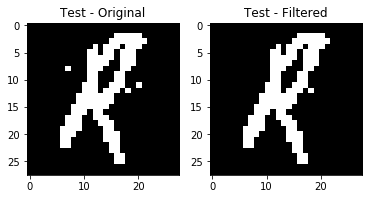

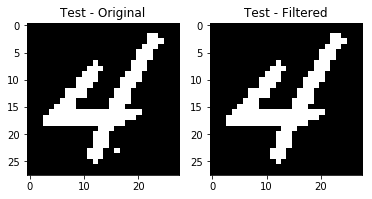

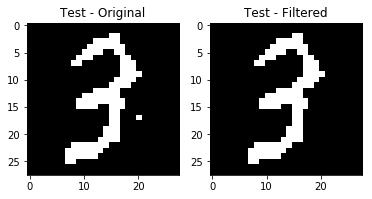

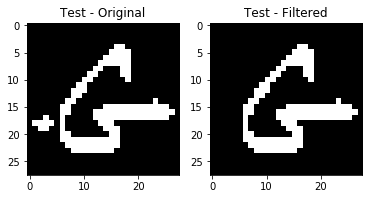

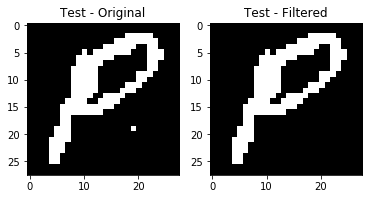

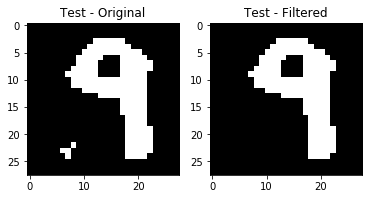

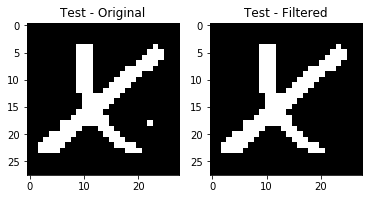

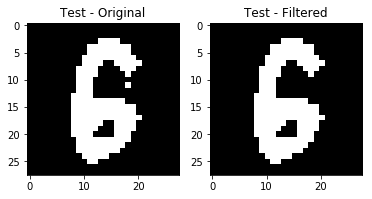

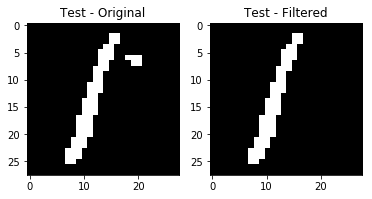

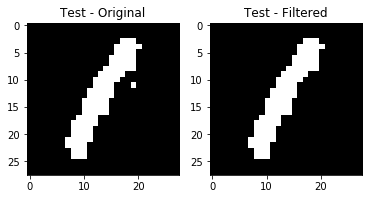

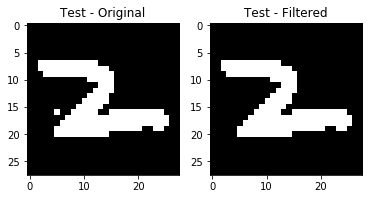

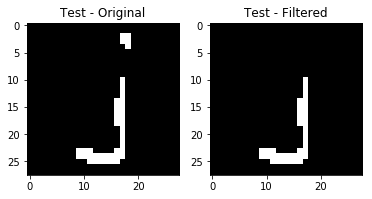

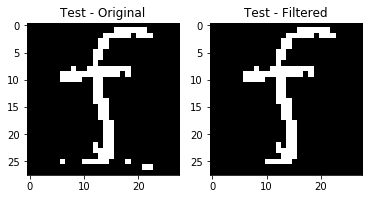

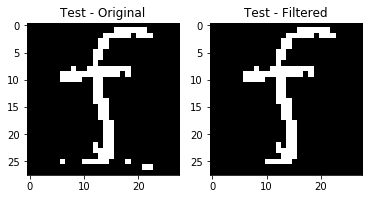

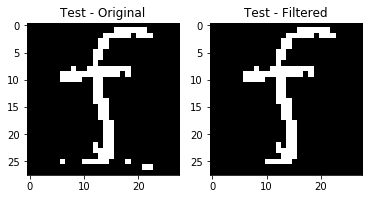

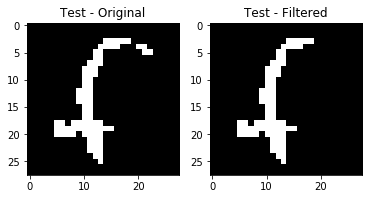

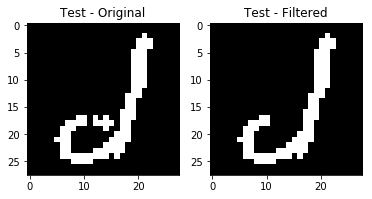

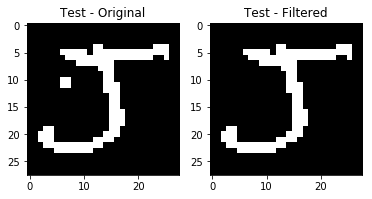

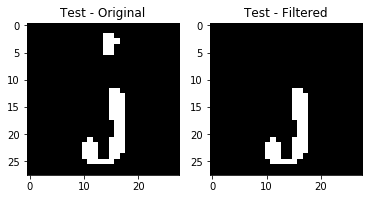

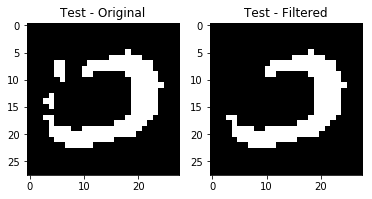

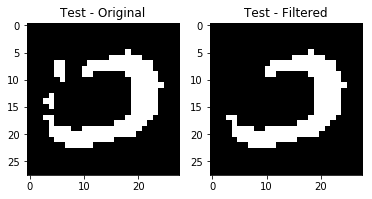

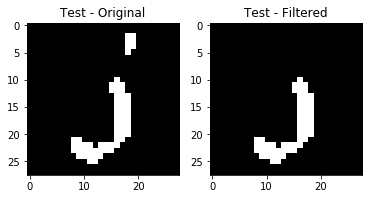

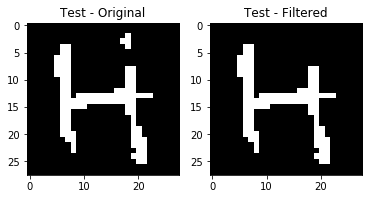

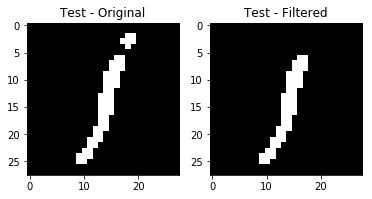

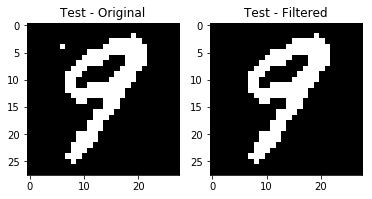

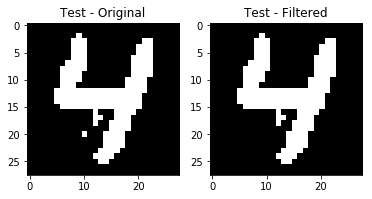

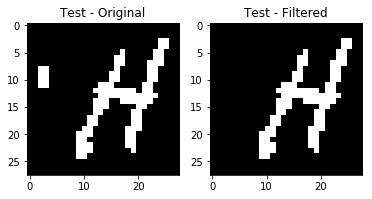

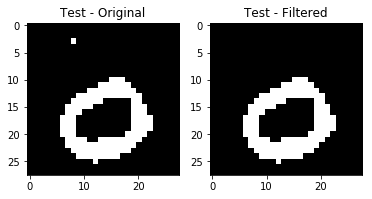

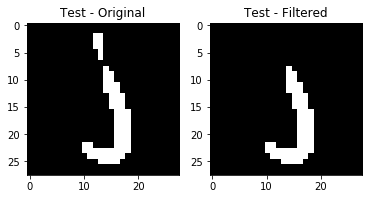

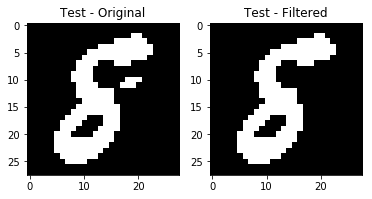

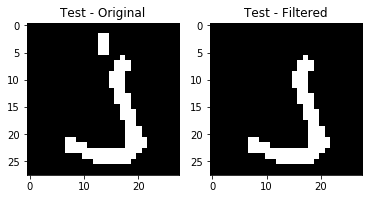

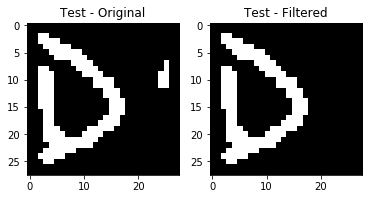

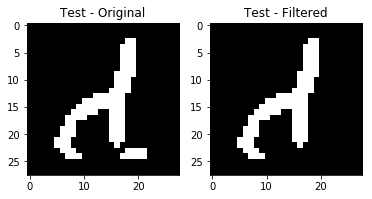

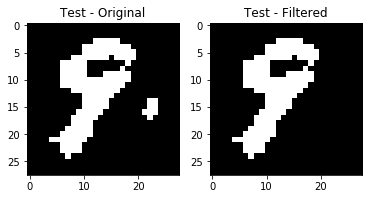

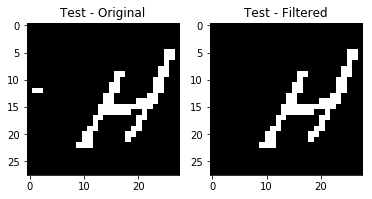

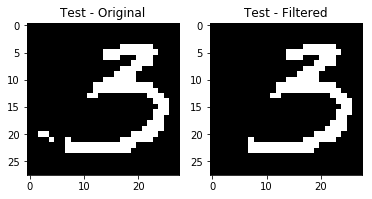

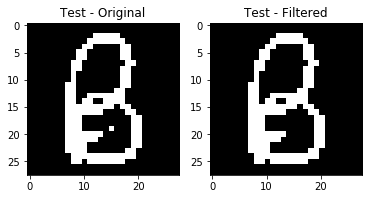

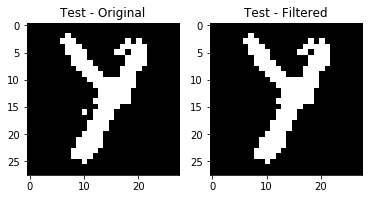

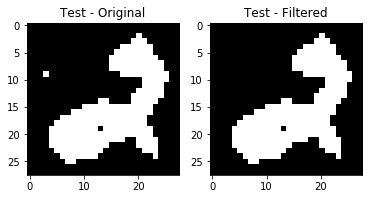

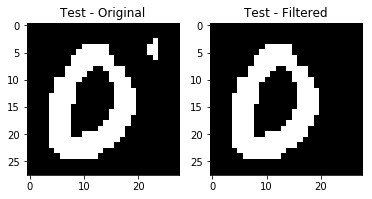

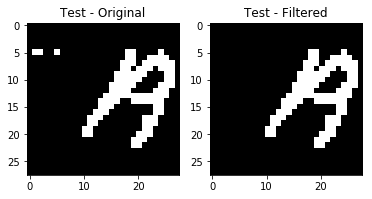

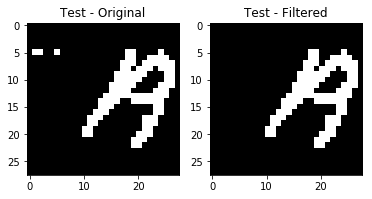

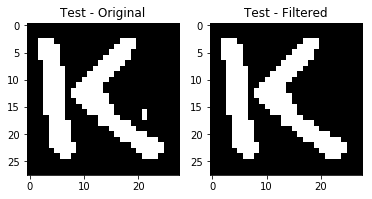

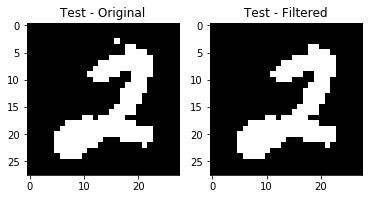

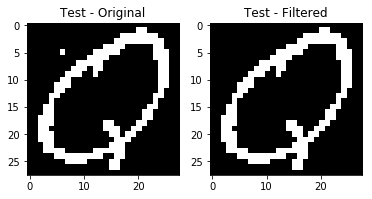

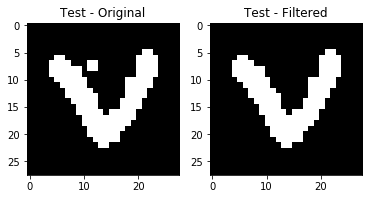

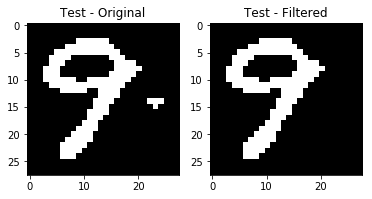

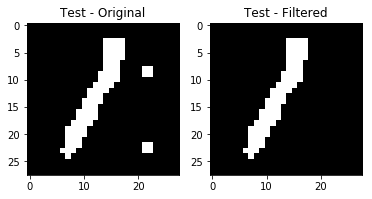

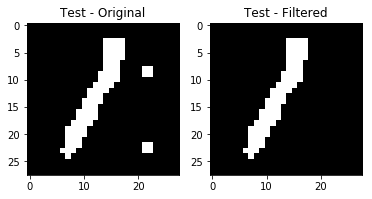

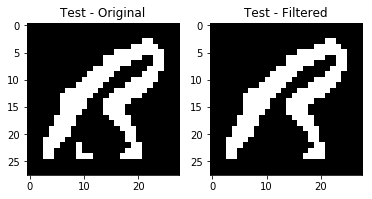

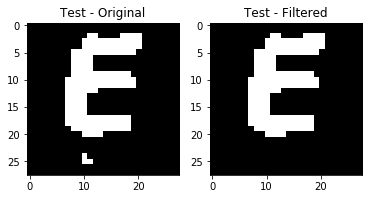

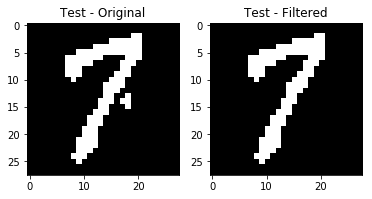

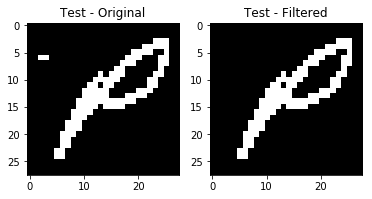

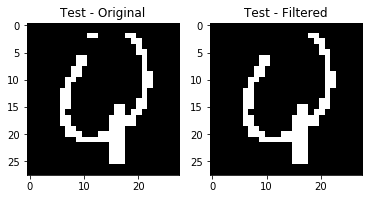

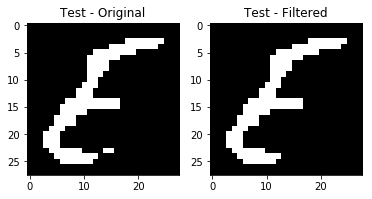

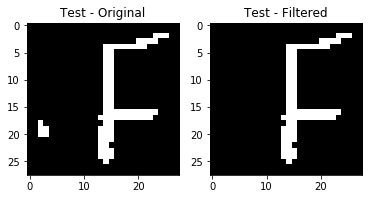

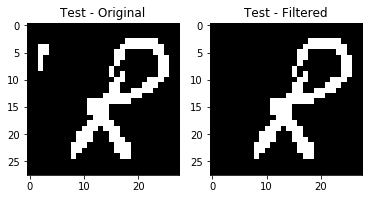

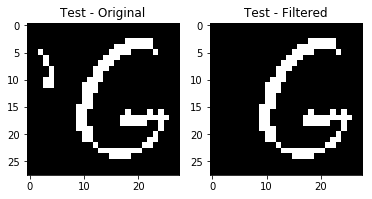

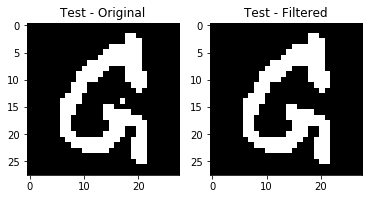

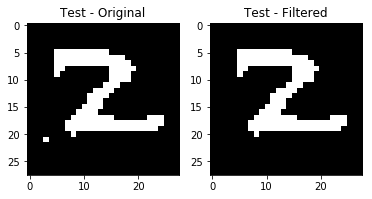

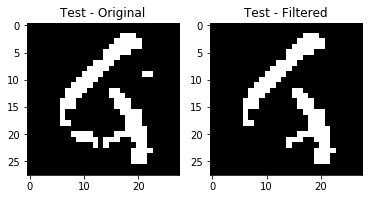

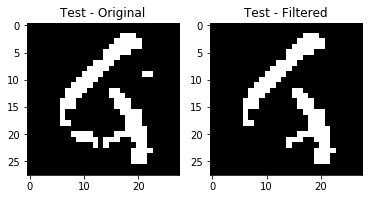

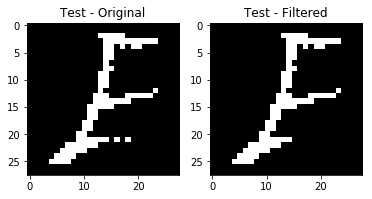

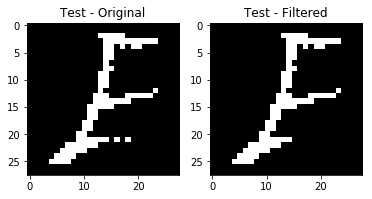

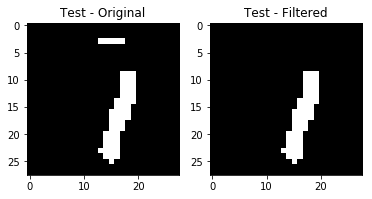

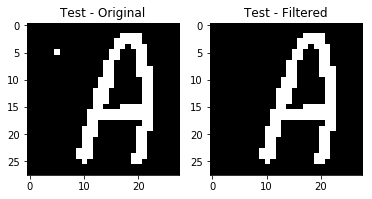

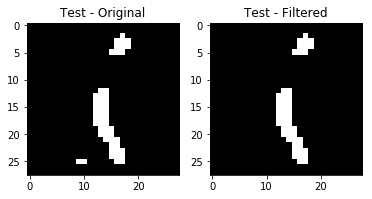

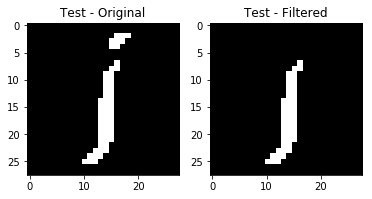

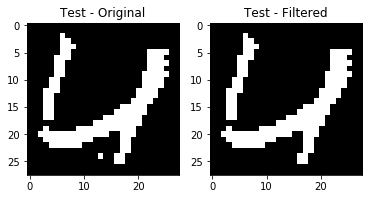

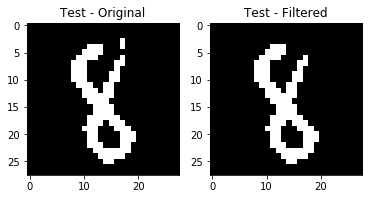

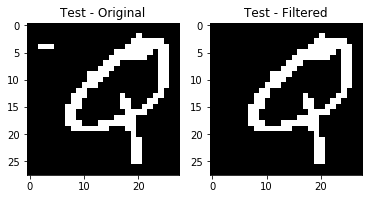

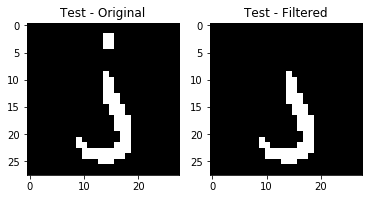

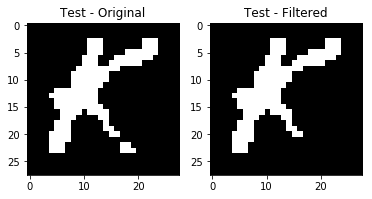

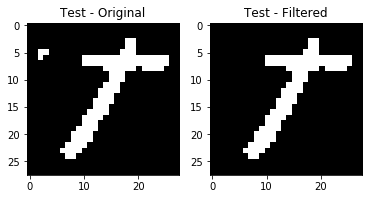

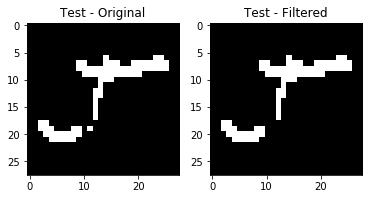

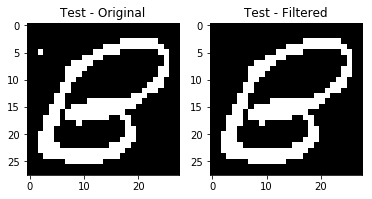

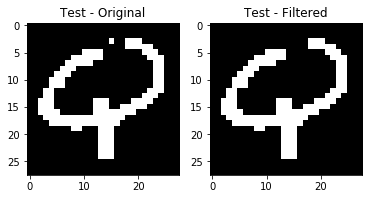

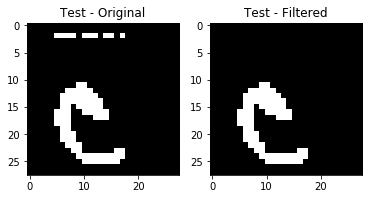

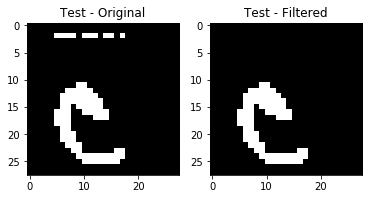

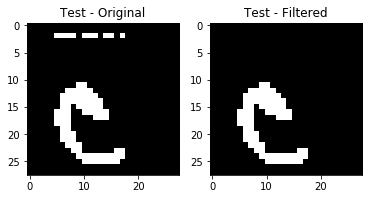

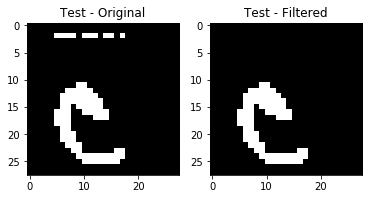

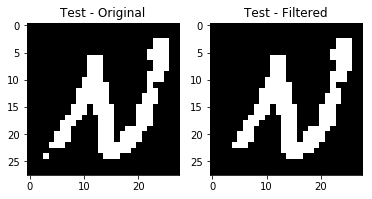

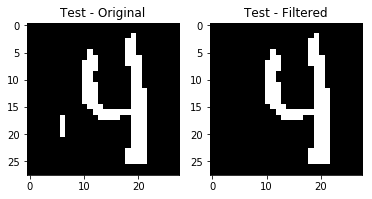

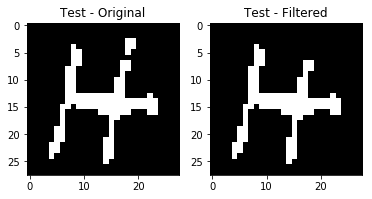

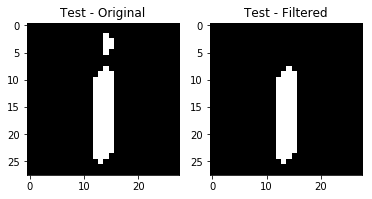

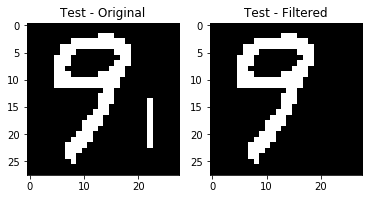

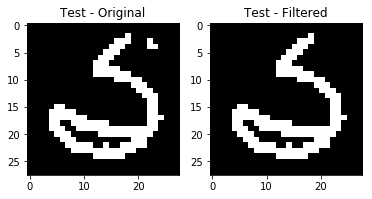

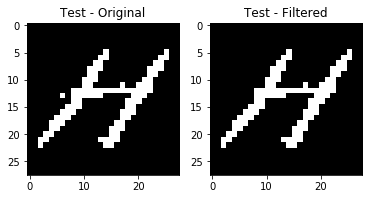

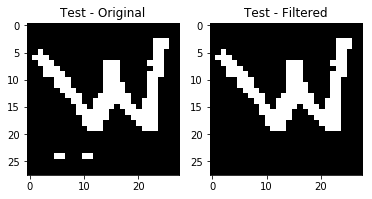

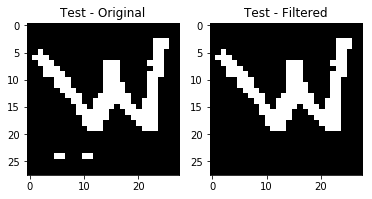

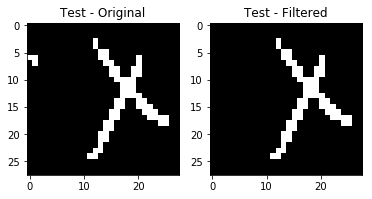

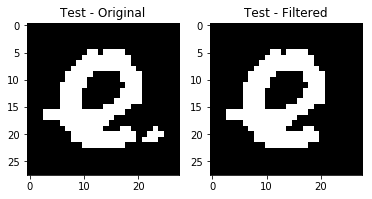

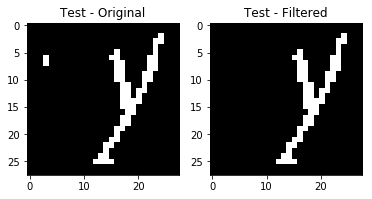

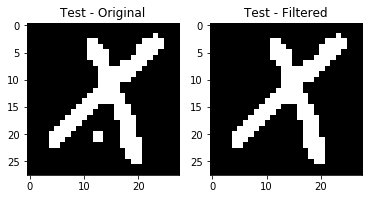

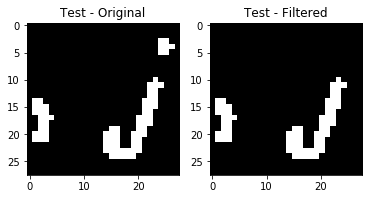

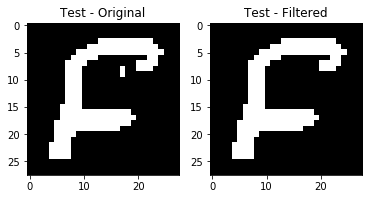

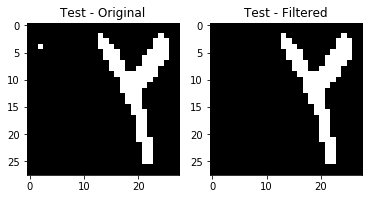

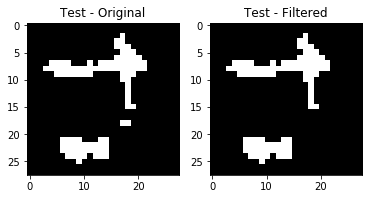

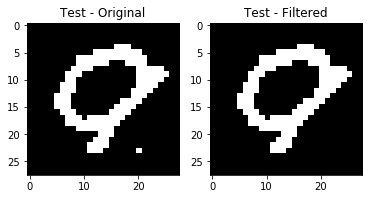

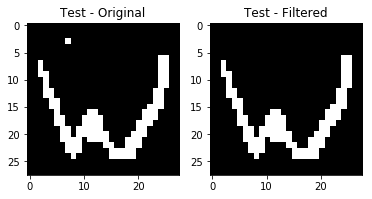

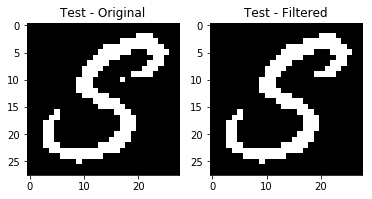

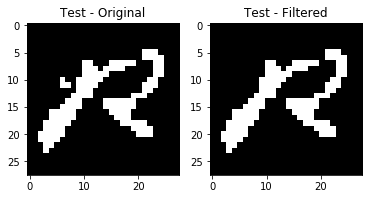

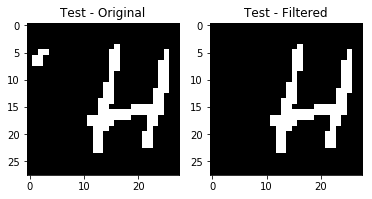

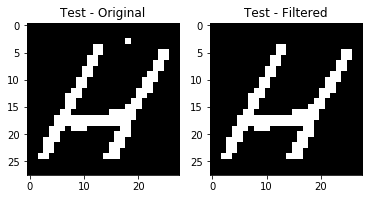

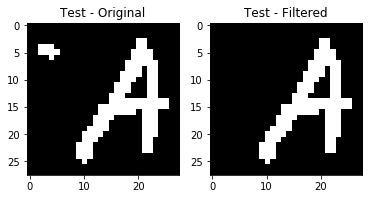

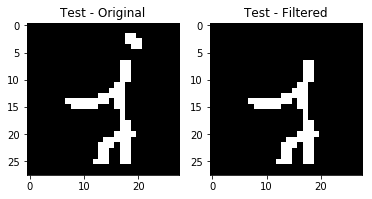

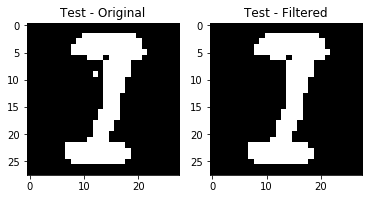

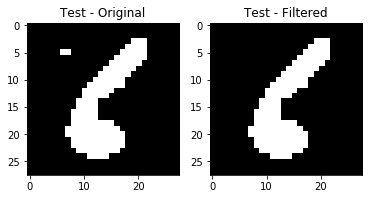

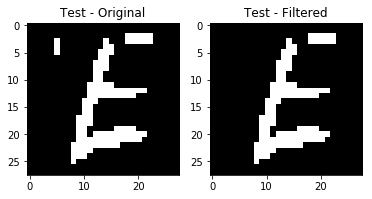

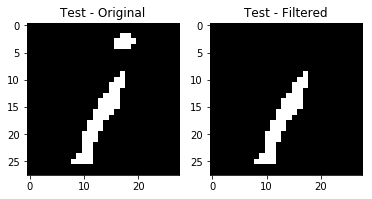

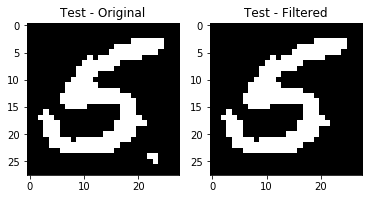

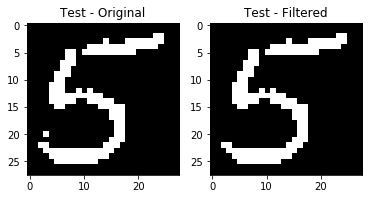

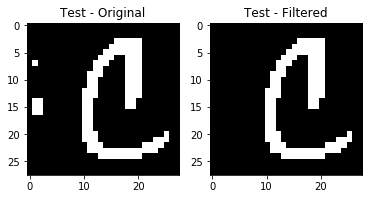

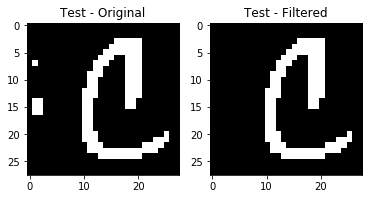

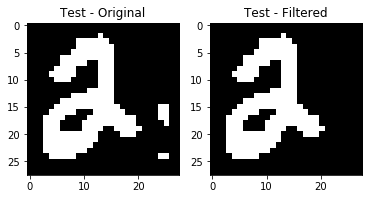

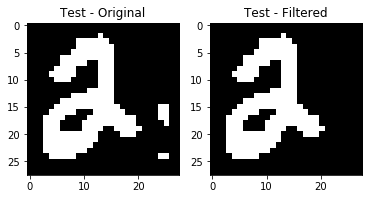

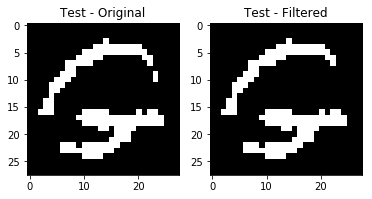

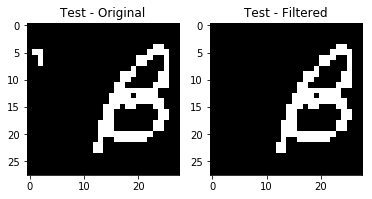

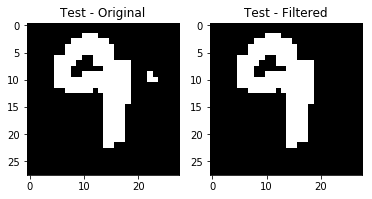

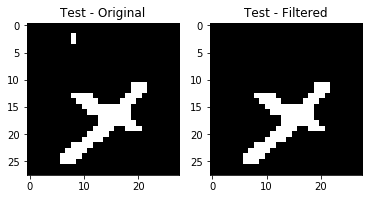

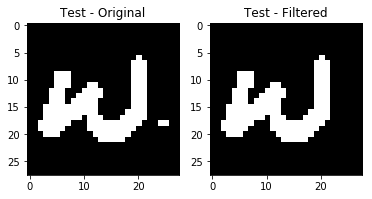

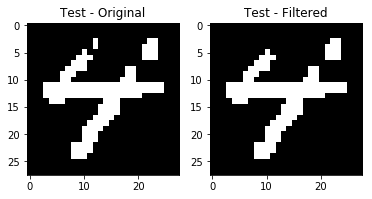

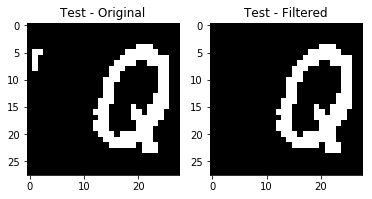

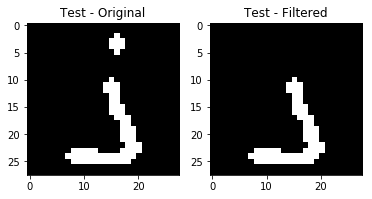

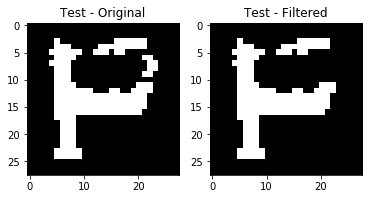

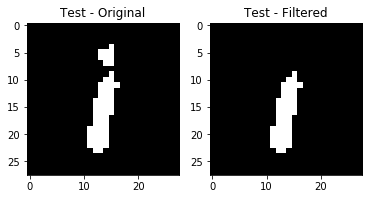

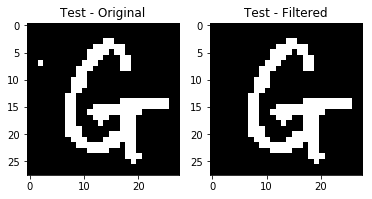

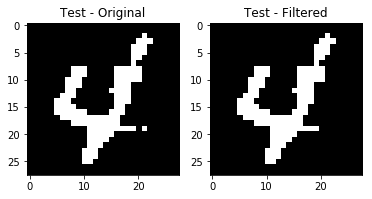

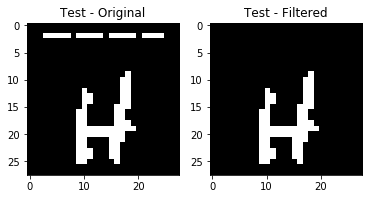

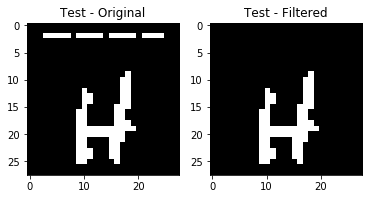

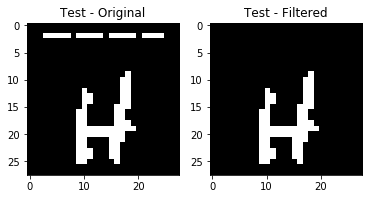

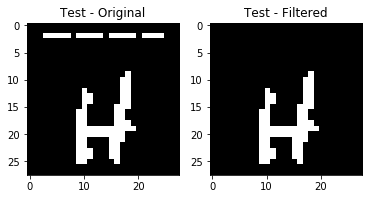

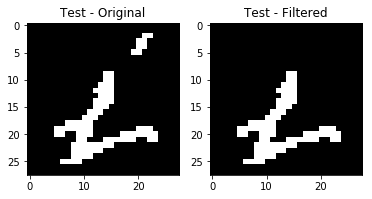

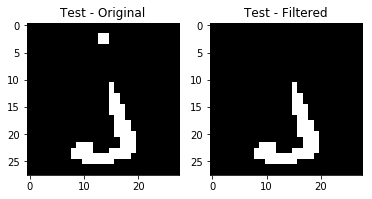

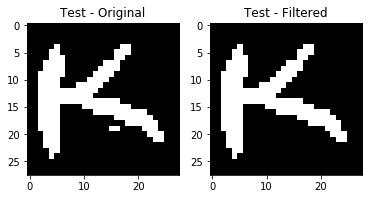

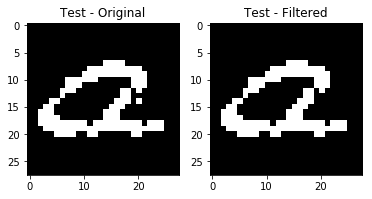

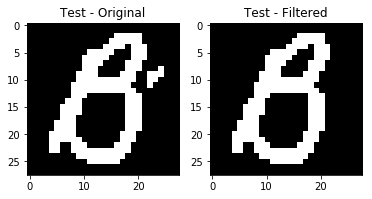

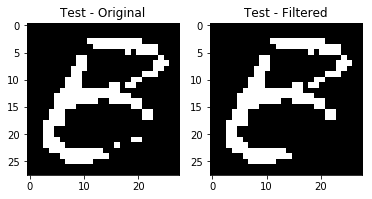

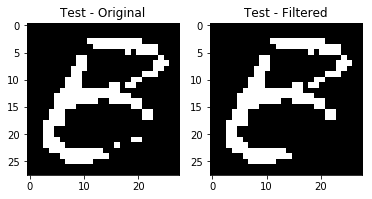

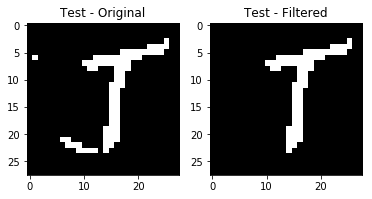

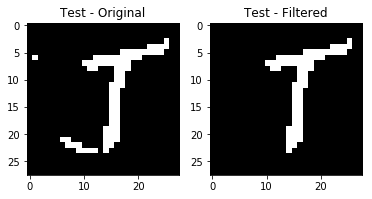

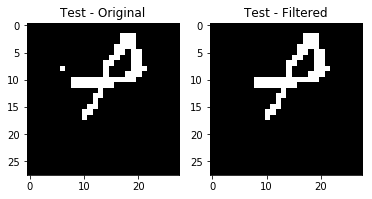

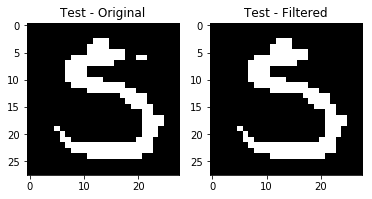

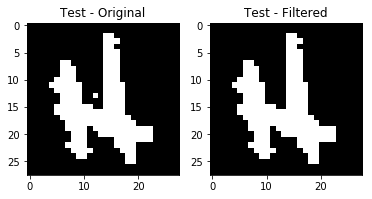

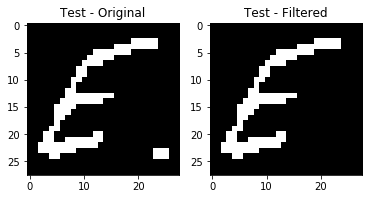

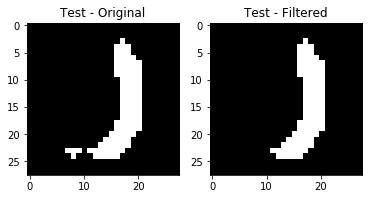

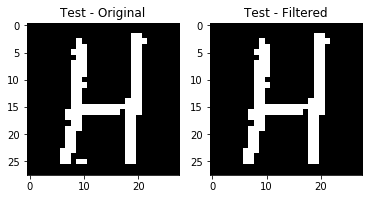

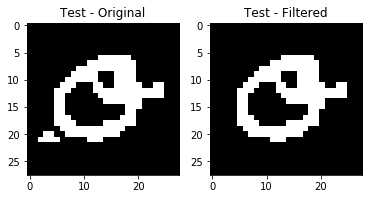

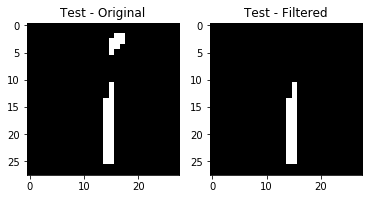

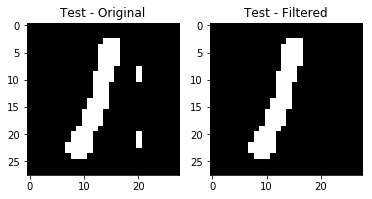

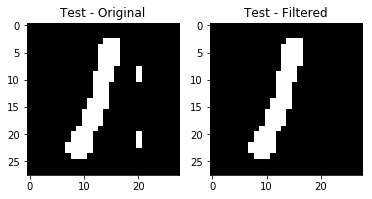

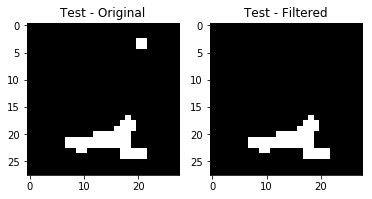

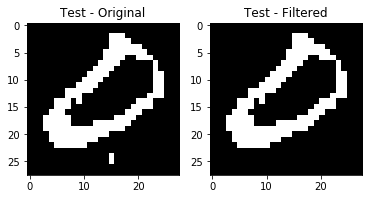

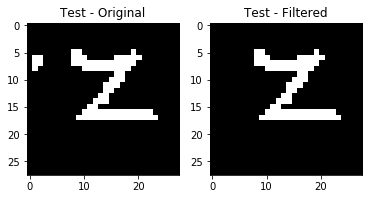

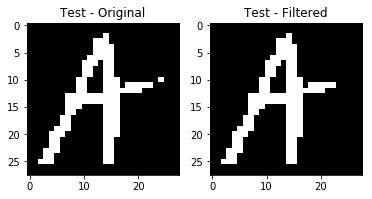

In [219]:
for i in coefst:
    plt.subplot(1, 2, 1)
    plt.imshow(X_test_otsu[i], cmap = 'gray')
    plt.title("Test - Original")
    plt.subplot(1, 2, 2)
    plt.imshow(X_test_otsu_clean[i], cmap = 'gray')
    plt.title("Test - Filtered")
    plt.show()

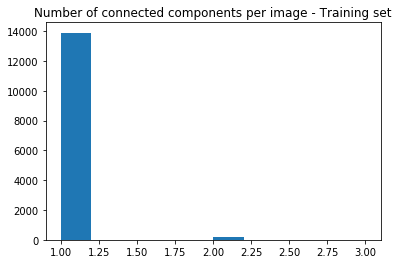

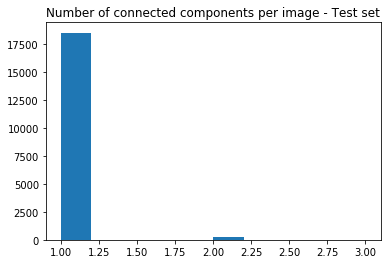

In [210]:
def hist_components(imgs, text):
    new_imgs = [label(img) for img in imgs]
    comps = [np.max(new_img) for new_img in new_imgs]
    plt.hist(comps)
    plt.title(text)
    plt.show()
hist_components(X_train_otsu_clean, "Number of connected components per image - Training set")
hist_components(X_test_otsu_clean, "Number of connected components per image - Test set")

# Extracting Features

## Imports

In [187]:
from skimage.measure import regionprops, label
from scipy import ndimage

## Feature extraction

In [228]:
def feature_extraction_1(image_bin, image_gray):
    features = []
    img_binl = label(image_bin)
    props = regionprops(label_image=img_binl, intensity_image=image_gray)
    max_comp = 0
    if np.max(img_binl) > 1:
        areas = [props[i].area for i in range(np.max(img_binl))]
        max_comp = np.argmax(areas)
        
    features.append(props[max_comp].area)
    features.append(props[max_comp].perimeter)
    bbox_xsize, bbox_ysize = props[max_comp].filled_image.shape
    #bbox_area, the props was giving a wrong value = the whole image, although bbox coords were correct.
    features.append(bbox_xsize*bbox_ysize) 
    features.append(props[max_comp].major_axis_length)
    features.append(props[max_comp].minor_axis_length)
    features.append(props[max_comp].solidity)
    features.append(props[max_comp].extent)
    features.append(props[max_comp].equivalent_diameter)
    features.append(props[max_comp].centroid[0])
    features.append(props[max_comp].centroid[1])
    features.append(props[max_comp].convex_area)
    # perimeter-area ratio
    features.append(features[1]/features[0])
    # elongation
    features.append(max(bbox_xsize, bbox_ysize)/min(bbox_xsize, bbox_ysize))
    # rectangularity
    features.append(features[3]/features[4])
    features.append(props[max_comp].weighted_centroid[0])
    features.append(props[max_comp].weighted_centroid[1])
    features.append(np.mean(image_gray))
    features.append(ndimage.standard_deviation(image_gray))
    return features


In [233]:
def feature_extraction_2(image_bin, image_gray):
    features = []
    img_binl = label(image_bin)
    props = regionprops(label_image=img_binl, intensity_image=image_gray)
    max_comp = 0
    if np.max(img_binl) > 1:
        areas = [props[i].area for i in range(np.max(img_binl))]
        max_comp = np.argmax(areas)
    
    features.append(props[max_comp].convex_area)
    features.append(props[max_comp].eccentricity)
    features.append(props[max_comp].equivalent_diameter)
    features.append(props[max_comp].euler_number)
    features.append(props[max_comp].extent)
    lcx, lcy = props[max_comp].local_centroid
    features.append(lcx)
    features.append(lcy)
    features.append(props[max_comp].mean_intensity)
    features.append(props[max_comp].major_axis_length)
    features.append(props[max_comp].minor_axis_length)
    features.append(props[max_comp].orientation)
    features.append(props[max_comp].perimeter)
    features.append(props[max_comp].solidity)
    features.append(props[max_comp].perimeter/props[max_comp].area)
    return features

In [241]:
f_train = []
f_test = []
f_valid = []

#isso está demorando bastante 
#for i in range(0, len(X_train)):
 #   f_train.append(feature_extraction(X_train[i]))

f_train = [feature_extraction_2(imageb, np.squeeze(imageg)) for imageb, imageg in zip(X_train_otsu_clean, X_train_red)]
print("Created train feature vector")

#for i in range(0, len(X_test)):
#   f_test.append(feature_extraction(X_test[i]))
 
f_test = [feature_extraction_2(imageb, np.squeeze(imageg)) for imageb, imageg in  zip(X_test_otsu_clean, X_test)]
print("Created test feature vector")

#for i in range(0, len(X_valid)):
#   f_valid.append(feature_extraction(X_valid[i]))

f_valid = [feature_extraction_2(imageb, np.squeeze(imageg)) for imageb, imageg in zip(X_valid_otsu, X_valid)]
print("Created valid feature vector")



# for i in range(0, len(f)):
#     print(f[i])


Created train feature vector
Created test feature vector
Created valid feature vector


# Fitting Classifiers

## Imports

In [240]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold


## Feature Selection


In [248]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
f_train_selection = sel.fit_transform(f_train)
f_test_selection = sel.fit_transform(f_test)
print(f_train_selection.shape, f_test_selection.shape)

(14100, 10) (18800, 10)


## Classification

In [249]:
f_test_norm = StandardScaler().fit_transform(f_test_selection)
f_train_norm = StandardScaler().fit_transform(f_train_selection)

In [250]:
gradient = GradientBoostingClassifier()
gradient.fit(f_train_norm, y_train_red)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [251]:
print(gradient.score(f_test_norm, y_test))
print(gradient.score(f_train_norm, y_train_red))

0.4197872340425532
0.7672340425531915


# Results

## Imports

In [255]:
from sklearn import metrics
import pprint

## Confusion Matrix

In [256]:
preds = gradient.predict(f_test_norm)
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, preds))

Confusion matrix:
[[176   0   0 ...   4   0   0]
 [  0 232   1 ...   0   0   2]
 [  5   0  84 ...   1   0   1]
 ...
 [  6   0   3 ...  75   1   1]
 [  1   0   0 ...   0 269   2]
 [  0   1   4 ...   0  15 175]]
